## Presentación

En esta instancia decidimos trabajar sobre un dataset acerca de Objetos Ceranos a la Tierra, NEO's por sus siglas en inglés (Near Earth Objects), y poder predecir si un cuerpo dado representa un peligro de impacto contra la Tierra. Pero nos encontramos con una peculiaridad; el dataset presenta una proporción desbalanceada de registros respecto a nuestra columna de interés a predecir. Esto significa que antes de poder aplicar alogritmos con fin de predicción, debemos hacernos cargo de este problema.

A lo largo de nuestro análisis, el enfoque con más peso será buscar la solución a esta problemática, aplicando distintas herramientas y evaluando sus desempeños a través de distintas métricas y comparando una a una, así poder llegar a una conlusión sobre cuál método fue el más beneficioso para la performance del algoritmo predictivo, además de poder ejemplificar por que tener un dataset desbalanceado presenta problemas a la hora de predecir.

### Objetivo general

- Evaluar como solucionar la problemática de que el dataset está desbalanceado respecto a la columna de interés a predecir
- Exponer los problemas que un dataset representa para el poder predictivo de un algoritmo


### Objetivos secundarios
- Analizar el dataset, buscar correlaciones entre variables y transformar datos
- Aplicar algoritmos de clasificacion para determinar si un NEO presenta peligro potencial de impacto

-----------------------------------

### Diccionario de datos:  

El dataset a trabajar cuenta con 18 columnas; aquí se expone que significa cada una de ellas:

- Unnamed: 0: Default index

- id: A unique ID given by NASA

- neo_reference_id: A unique ID given by NASA to all NEO, same as the ID

- name: Official name given by NASA

- name_limited: Normal name without the scientific notations

- designation: The number used in the official name given by NASA

- absolute_magnitude_h: Absolute magnitude (M) is a measure of the luminosity of a celestial object, on an inverse logarithmic astronomical

- is_potentially_hazardous_asteroid: Boolean value which tells if the object poses a threat to earth or not

- is_sentry_object: Boolean value which tells if the object is present in the sentry tracking system or not (Sentry: https://en.wikipedia.org/wiki/Sentry_(monitoring_system))

- kilometers_estimated_diameter_min: Minimum estimated diameter in kilometer

- kilometers_estimated_diameter_max: Maximum estimated diameter in kilometer

- orbit_id: A unique ID for the orbit of the object

- orbit_class_type: Classification of the object orbit into classes

    - (AMO is referring to Amor asteroids: near-Earth asteroids. The orbital perihelion of these objects is close to, but greater than, the orbital aphelion of Earth (a > 1.0 AU and 1.017 AU < q < 1.3 AU).

    - APO is referring to Apollo asteroids: near-Earth asteroid orbits which cross the Earth's orbit (a > 1.0 AU and q < 1.017 AU).)

    (Consultar Más información sobre la clasificación de órbita)

- perihelion_distance: Has the perihelion distance (the point nearest to the Earth in the path of an orbiting celestial body)

- aphelion_distance: Has the aphelion distance (the point in the orbit of a planet, asteroid, or object at which it is furthest from the Earth)

- first_observation_date: Date when the object was first observed

- last_observation_date: Date when the object was last observed

- orbit_class_description: The description of the orbit

(Diccionario extrído de la fuente)

#### Más información sobre la clasificación de órbita

Asteroids are dynamically classified as "Near-Earth" if their perihelion distance is less than 1.3 AU. They are further divided into groups based on their semi-major axis (a), perihelion distance (q), and aphelion distance (Q).

- Apollos (APO) cross Earth's orbit and have a semi-major axis of more than 1 AU

- Amors (AMO) have orbits strictly outside Earth's orbit

- Atens (ATE) cross Earth's orbit and have a semi-major axis of less than 1 AU

- Atiras (IEO) have orbits strictly inside Earth's orbit

Fuente de los datos a trabajar: https://www.kaggle.com/datasets/adityaramachandran27/nasa-near-earth-objects-information

________________________________________________

In [1]:
#Instalación e importación de librerías

!pip install --upgrade pip
!pip install -r ../requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import boxcox
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [259]:
#Lectura de datos

df_raw = pd.read_csv('../data/nasa_neo.csv')

-------------------------

### Información general sobre los datos

Aquí solamente vamos a realizar un pantallazo general de los datos y poder ver frente a que nos estamos enfrentando

In [260]:
#Información general de los datos a analizar

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         24000 non-null  int64  
 1   id                                 24000 non-null  int64  
 2   neo_reference_id                   24000 non-null  int64  
 3   name                               24000 non-null  object 
 4   name_limited                       144 non-null    object 
 5   designation                        24000 non-null  object 
 6   absolute_magnitude_h               23992 non-null  float64
 7   is_potentially_hazardous_asteroid  24000 non-null  bool   
 8   is_sentry_object                   24000 non-null  bool   
 9   kilometers_estimated_diameter_min  23992 non-null  float64
 10  kilometers_estimated_diameter_max  23992 non-null  float64
 11  orbit_id                           24000 non-null  obj

Observar que hay datos faltantes en columnas como 'absolute_magnitude_h ' y 'name_limited'. En el segundo caso es porque NASA no le asigna nombres propios a todos los cuerpos

In [261]:
# Drop de columna Unnamed (index de sobra)

df_raw.drop(columns = ['Unnamed: 0'], inplace = True)

In [262]:
#Información estadística de las variables continuas para poder analizar sus distribuciones correspondientes

df_raw.describe()

,id,neo_reference_id,absolute_magnitude_h,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,perihelion_distance,aphelion_distance
count,2.400000e+04,2.400000e+04,23992.000000,23992.000000,23992.000000,24000.000000,24000.000000
mean,7.275111e+06,7.275111e+06,22.942274,0.167777,0.375160,0.915225,2.653104
std,1.333987e+07,1.333987e+07,2.952871,0.293000,0.655169,0.232201,4.468233
min,2.001981e+06,2.001981e+06,12.580000,0.000609,0.001362,0.070431,0.653754
25%,3.409962e+06,3.409962e+06,20.650000,0.024241,0.054205,0.785150,1.706281
50%,3.703790e+06,3.703790e+06,23.200000,0.060891,0.136157,0.965325,2.480109
75%,3.803897e+06,3.803897e+06,25.200000,0.197040,0.440595,1.068984,3.397965
max,5.408749e+07,5.408749e+07,33.200000,8.101305,18.115068,1.299988,631.895456


In [263]:
#Informacion estadística de las variables categóricas

df_raw.describe(include = ['object','bool'])

,name,name_limited,designation,is_potentially_hazardous_asteroid,is_sentry_object,orbit_id,orbit_class_type,first_observation_date,last_observation_date,orbit_class_description
count,24000,144,24000,24000,24000,24000,24000,24000,24000,24000
unique,24000,144,24000,2,2,352,4,5964,5016,4
top,1981 Midas (1973 EA),Midas,1981,False,False,7,APO,2014-04-23,2022-04-15,Near-Earth asteroid orbits which cross the Ear...
freq,1,1,1,21906,22934,1485,13245,67,40,13245


Podemos ver que la asignación de nombres por parte de la NASA es única, ya que en las columnas 'name', 'name_limited' y 'designation' tenemos todos valores únicos. Vamos a chequear también en la columna 'id' si se cumple. Si el resultado es false, significa que los ids también son todos únicos

In [264]:
df_raw['id'].duplicated().any()

False

#### Observaciones

- Las columnas 'id' y 'neo_reference_id' son idénticas, así que nos podemos quedar solo con una de ellas
- La columna 'name_limited' es simplemente la extracción del nombre propio del cuerpo (si es que lo tiene), dato que ya esta en la columna 'name', por lo que no nos aporta información relevante, más allá de sacar la proporción de cuerpos a los que la NASA le ha asignado un valor propio. 
- Algo similar sucede con la columna 'designation', la cual también es una parte del nombre oficial establecido, y el dato completo del nombre está en la columna 'name'

In [266]:
df_raw.drop(columns = ['neo_reference_id', 'name_limited', 'designation'], inplace = True)

__________________________________

## Exploratory Data Analysis (EDA)

En esta sección nos enfocamos en explorar los datos, de esta manera poder encontrar anomalías en datos, distribuciones interesantes, etc. En general buscamos de que maneras podemos mejorar los datos, aplicaciones a realizar luego en la sección de tratamiento de datos

Separamos nuestro dataset en entrenamiento, validación y prueba

In [268]:
y = df_raw['is_potentially_hazardous_asteroid']
X = df_raw.drop(columns = ['is_potentially_hazardous_asteroid'])

X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8,stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,stratify=y_rem, random_state=42)

# Para trabajar en el eda
X_united = pd.concat([X_train, X_valid])
y_united = pd.concat([y_train, y_valid])
df_united = pd.concat([X_united, y_united], axis=1)

# X_train.to_csv('../data/raw/X_train.csv')
# y_train.to_csv('../data/raw/y_train.csv')

# X_valid.to_csv('../data/raw/X_valid.csv')
# y_valid.to_csv('../data/raw/y_valid.csv')

# X_test.to_csv('../data/raw/X_test.csv')
# y_test.to_csv('../data/raw/y_test.csv')

df_raw.to_csv('../data/raw/df_raw.csv')

<br>

### Distribución de variables categoricas

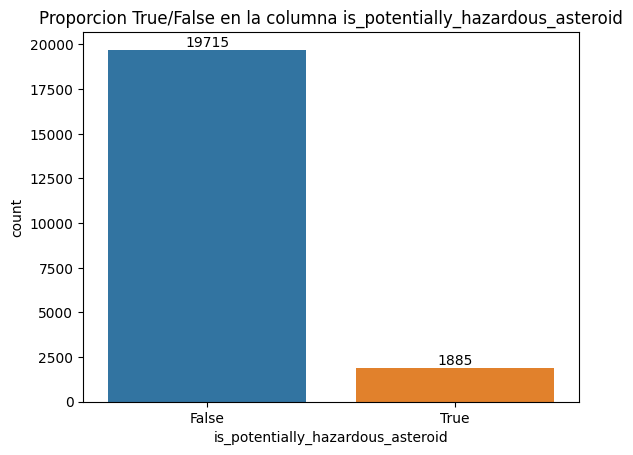

In [271]:
# is_potentially_hazardous_asteroid

ax = sns.countplot(x = df_united['is_potentially_hazardous_asteroid'])
ax.bar_label(ax.containers[0])
plt.title('Proporcion True/False en la columna is_potentially_hazardous_asteroid')
plt.show()

Aquí podemos apreciar de que hablabamos al principio sobre el desbalance de los datos en esta columna

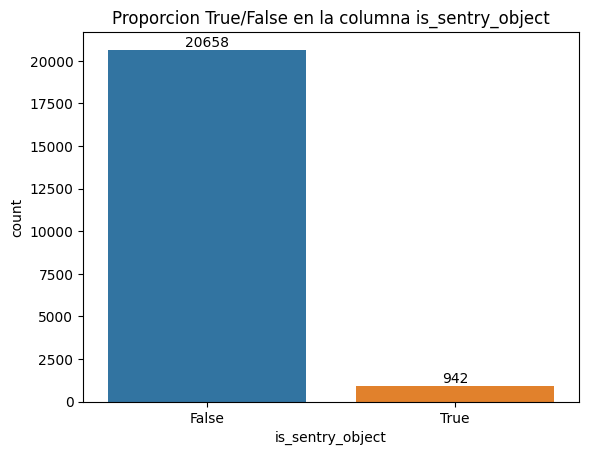

In [272]:
# is_sentry_object

ax = sns.countplot(x = df_united['is_sentry_object'])
ax.bar_label(ax.containers[0])
plt.title('Proporcion True/False en la columna is_sentry_object')
plt.show()

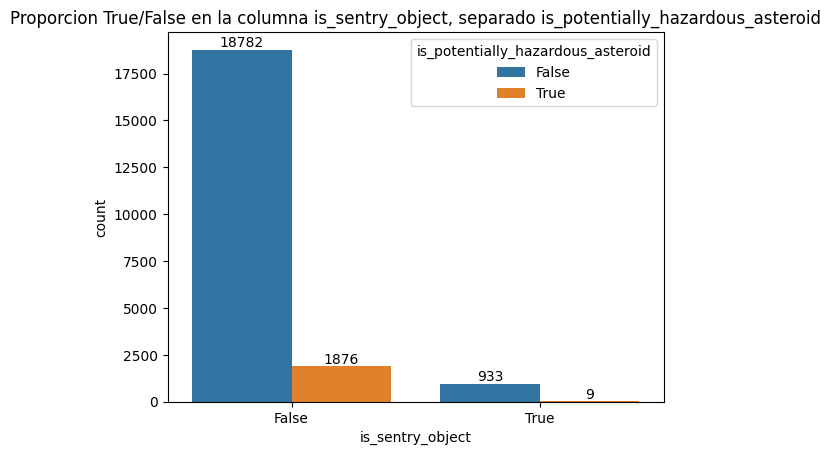

In [273]:
ax = sns.countplot(data = df_united, x = 'is_sentry_object', hue = 'is_potentially_hazardous_asteroid')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Proporcion True/False en la columna is_sentry_object, separado is_potentially_hazardous_asteroid')
plt.show()

Hay registros que son potencialmente peligrosos, pero que no se encuentran en el sistema de monitoreo Sentry

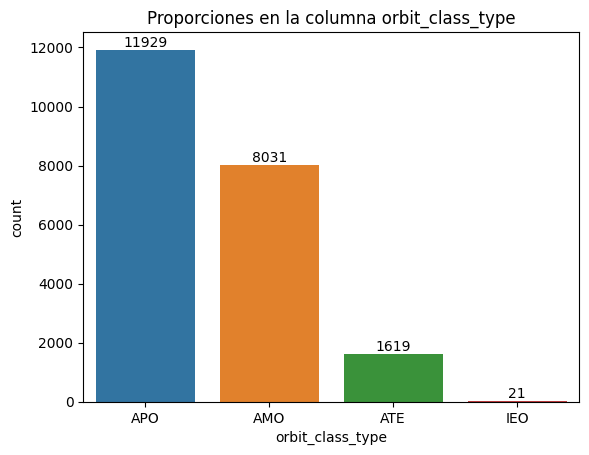

In [274]:
# Distribucion de categorias en columna 'orbit_class_type'

ax = sns.countplot(x = df_united['orbit_class_type'])
ax.bar_label(ax.containers[0])
plt.title('Proporciones en la columna orbit_class_type')
plt.show()

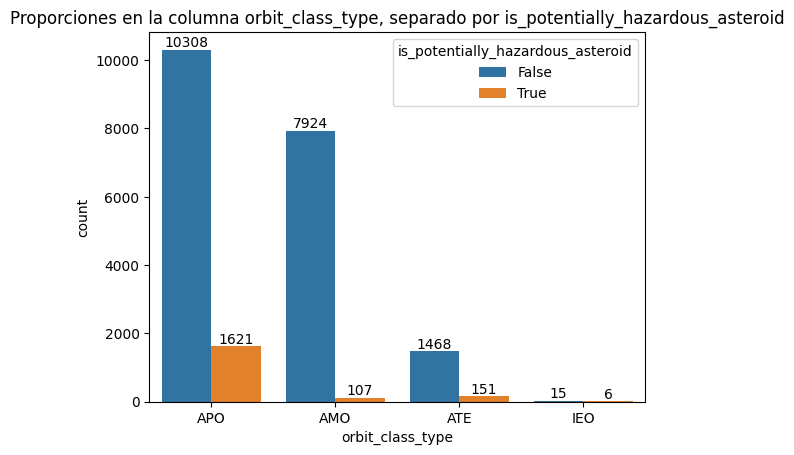

In [275]:
ax = sns.countplot(data = df_united, x = 'orbit_class_type', hue = 'is_potentially_hazardous_asteroid')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.title('Proporciones en la columna orbit_class_type, separado por is_potentially_hazardous_asteroid')
plt.show()

<br>

### Distribución de variables continuas

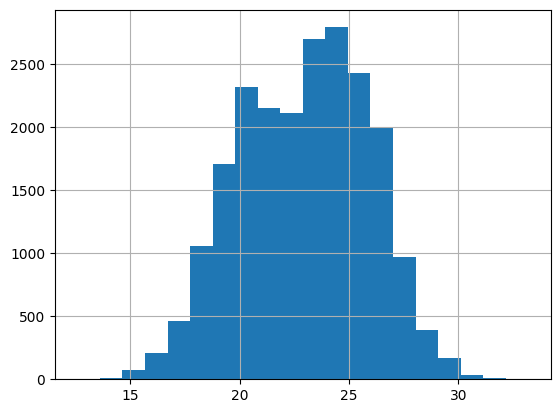

In [276]:
# Distribucion de valores de la columna 'absolute_magnitude_h'

df_united['absolute_magnitude_h'].hist(bins = 20)
plt.show()

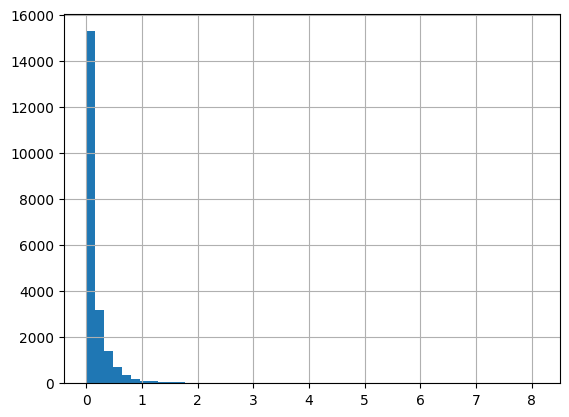

In [277]:
# Distribucion de valorea de la columna 'kilometers_estimated_diameter_min'

df_united['kilometers_estimated_diameter_min'].hist(bins=50)
plt.show()

# El mayor valor registrado es 8.1013048824

Se acotan superiormente los valores de la columna para graficar y ver mejor la distribución, ya que presenta un marcado sesgo positivo

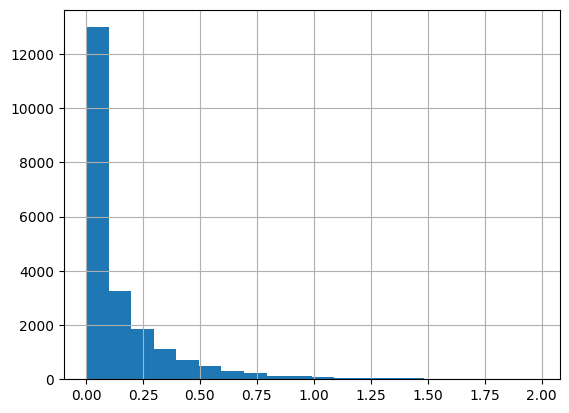

In [278]:
df_united[df_united['kilometers_estimated_diameter_min'] < 2]['kilometers_estimated_diameter_min'].hist(bins=20)
plt.show()

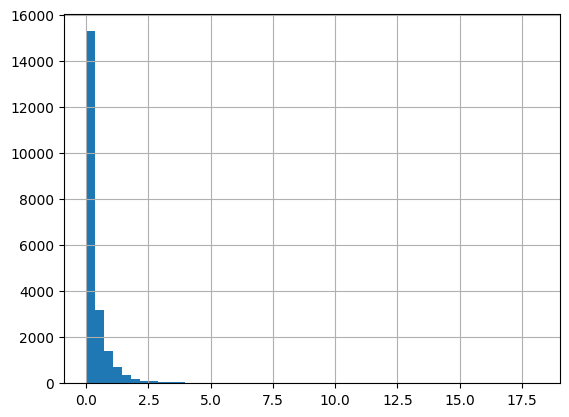

In [279]:
# distribucion de valores de la columna 'kilometers_estimated_diameter_max'

df_united['kilometers_estimated_diameter_max'].hist(bins=50)
plt.show()

# El mayor valor registrado es 18.1150684236

Igual que antes, se acotan los valores para poder apreciar mejor la grafica, debido al marcado sesgo positivo de la distribución

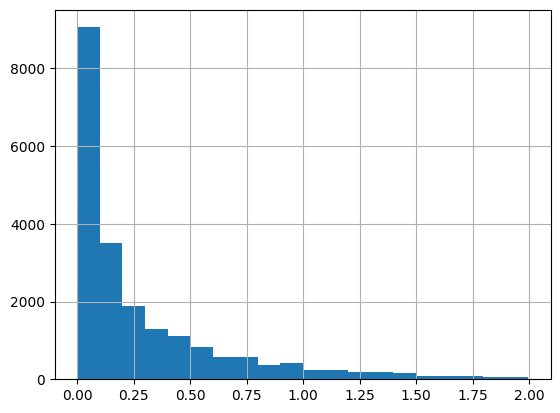

In [280]:
df_united[df_united['kilometers_estimated_diameter_max'] < 2]['kilometers_estimated_diameter_max'].hist(bins=20)
plt.show()

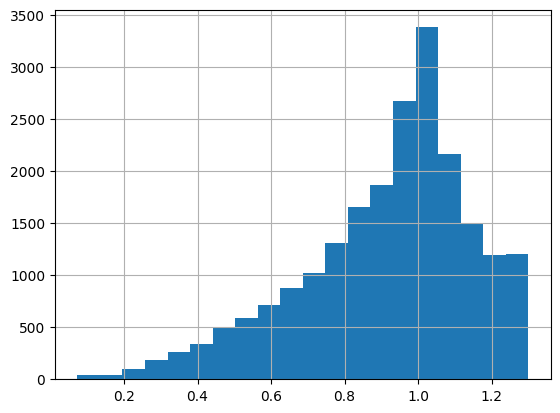

In [281]:
# Distribucion de valores de la columna 'perihelion_distance'

df_united['perihelion_distance'].hist(bins=20)
plt.show()

# La distribucion de esta columna en cambio presenta sesgo negativo

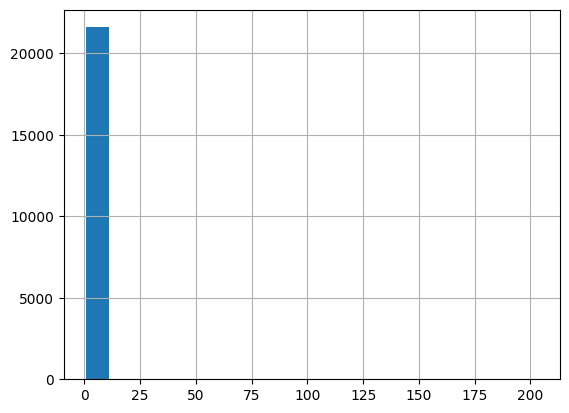

In [282]:
# Distribucion de valores de la columna 'aphelion_distance'

df_united['aphelion_distance'].hist(bins=20)
plt.show()

# El mayor valor registrado es 631.8954563363584

Se acotan los valores de la columna para poder apreciar mejor la distribución

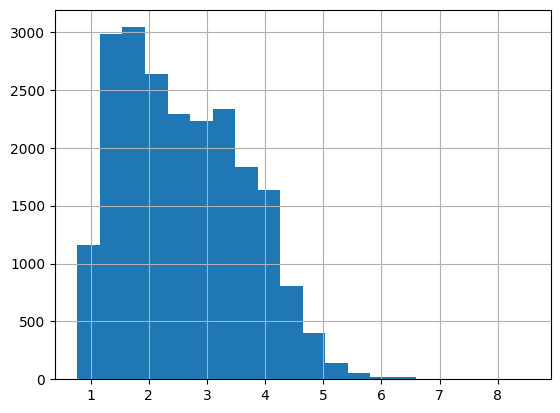

In [283]:
df_united[df_united['aphelion_distance'] < 10]['aphelion_distance'].hist(bins=20)
plt.show()

Efectivamente esta distribucion tambien presenta sesgo positivo

<br>

### Matriz de correlaciones

Nos interesa ver la correlación con las variables 'orbit_class_type' y 'orbit_class_description', por lo que aplicamos las transformaciones necesarias para ello

In [285]:
# Codigo extraido de la parte de transformacion

df_united['orbit_class_type'] = pd.Categorical(df_united['orbit_class_type'])
df_united['orbit_class_type'] = df_united['orbit_class_type'].cat.codes

df_united['orbit_class_description'] = pd.Categorical(df_united['orbit_class_description'])
df_united['orbit_class_description'] = df_united['orbit_class_description'].cat.codes

Buscar correlaciones con la columna de identificación (id) no tiene sentido, así que volvemos a hacer la correlación sin ella

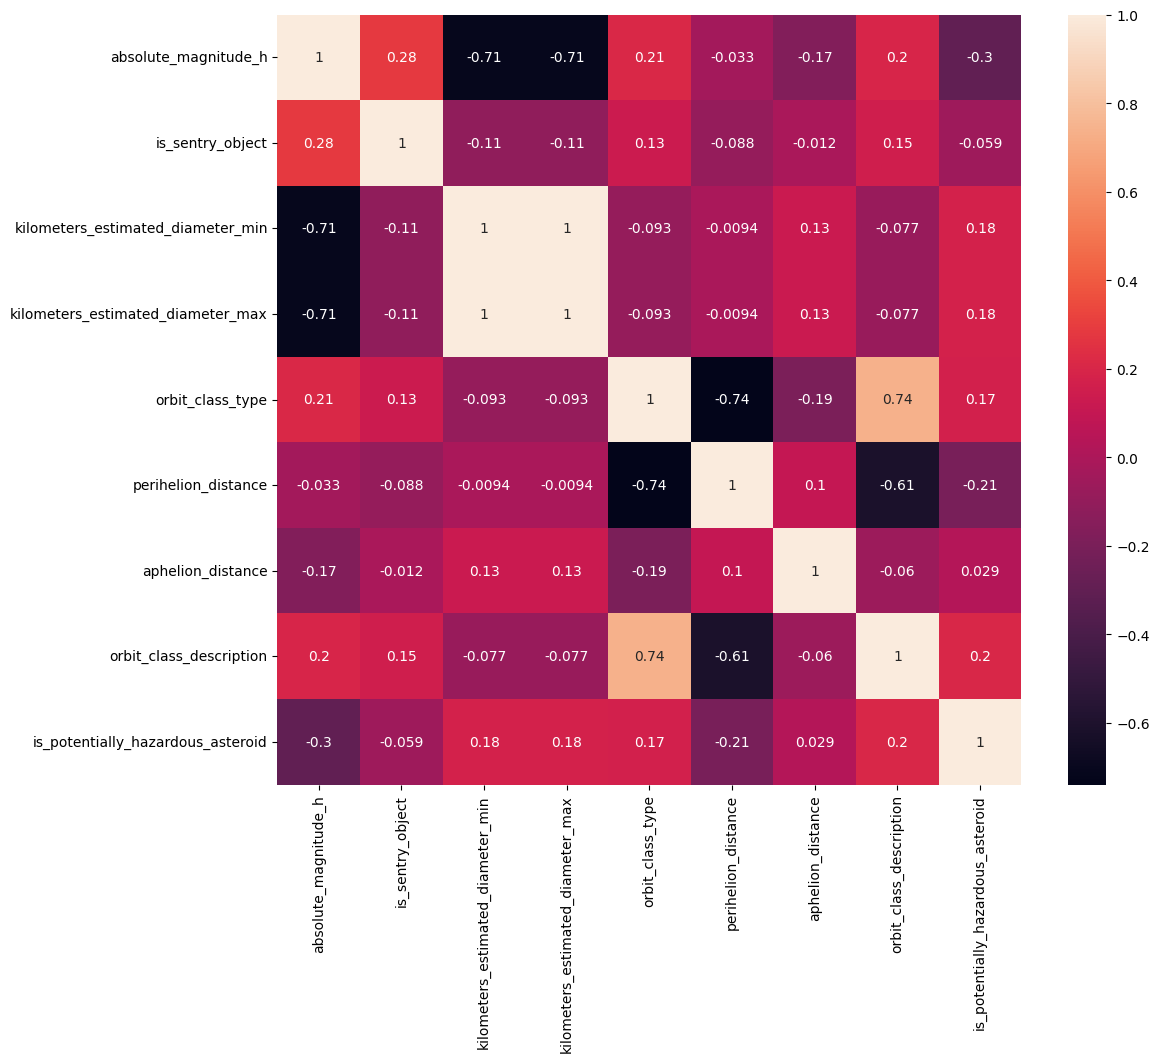

In [287]:
df_wo_ids = df_united.drop(columns = ['id'])

fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(df_wo_ids.corr(), annot = True, ax=ax)
plt.show()

#### Observaciones:
(Consideramos fuerte correlacion por encima de 0.75 (o por debajo de -0.75))  
No hay correlaciones fuertes respecto a nuestro target

<br>

### Pairplot

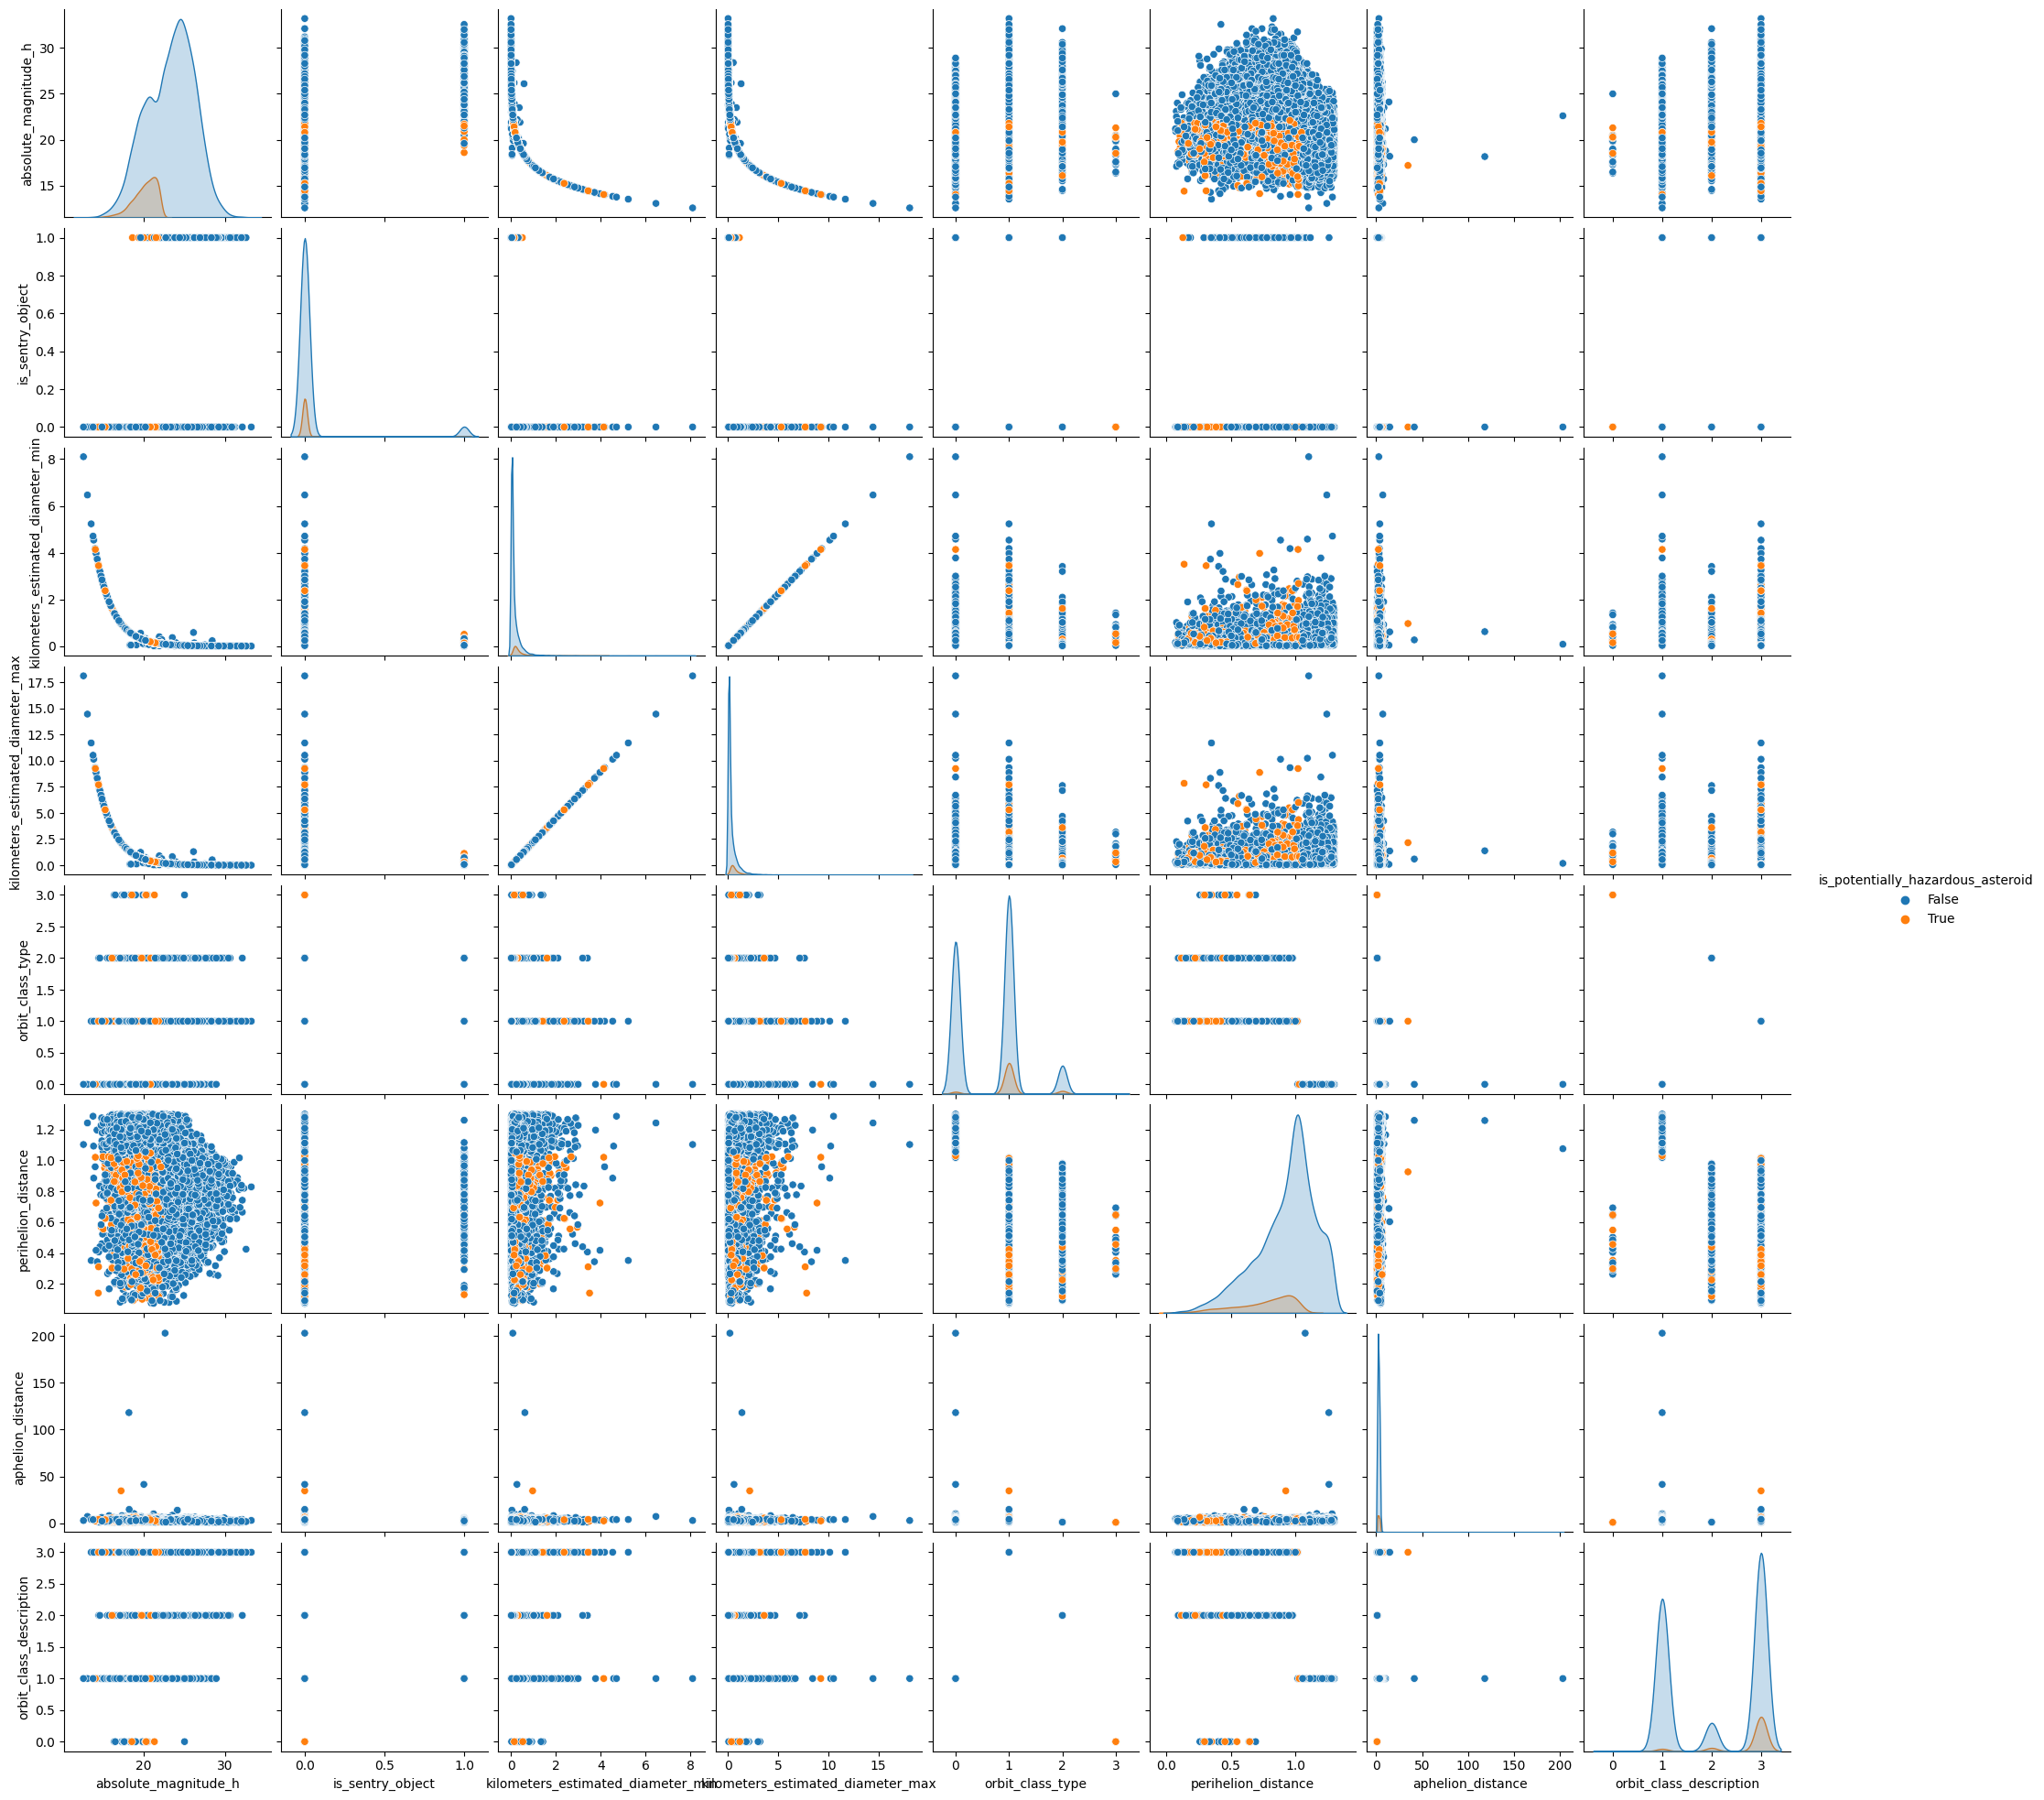

In [288]:
# se sacan las variables de tipo object, bool y de identificacion que no interesan para el pairplot
df_for_pairplot = df_united.drop(columns = ['id', 'name', 'orbit_id', 'first_observation_date', 'last_observation_date'])

df_for_pairplot['is_sentry_object'] = pd.Categorical(df_for_pairplot['is_sentry_object'])
df_for_pairplot['is_sentry_object'] = df_for_pairplot['is_sentry_object'].cat.codes

sns.pairplot(data = df_for_pairplot , hue = 'is_potentially_hazardous_asteroid')
plt.show()

<br>

### Multicolinearidad

In [289]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Transformaciones necesarias para vif
df_for_vif = df_united.drop(columns = ['id', 'name', 'orbit_id', 'first_observation_date', 'last_observation_date'])

df_for_vif['is_potentially_hazardous_asteroid'] = pd.Categorical(df_for_vif['is_potentially_hazardous_asteroid'])
df_for_vif['is_potentially_hazardous_asteroid'] = df_for_vif['is_potentially_hazardous_asteroid'].cat.codes

df_for_vif['is_sentry_object'] = pd.Categorical(df_for_vif['is_sentry_object'])
df_for_vif['is_sentry_object'] = df_for_vif['is_sentry_object'].cat.codes

y, X = dmatrices('is_potentially_hazardous_asteroid ~ absolute_magnitude_h+is_sentry_object+orbit_class_type+kilometers_estimated_diameter_max+perihelion_distance+aphelion_distance+orbit_class_description', data=df_for_vif, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,191.725003,Intercept
1,2.384587,absolute_magnitude_h
2,1.120155,is_sentry_object
3,3.308974,orbit_class_type
4,2.090032,kilometers_estimated_diameter_max
5,2.350250,perihelion_distance
6,1.079306,aphelion_distance
7,2.305776,orbit_class_description


Podemos ver que no hay presencia de multicolinearidad alta (se considera fuerte multicolinearidad valores mayores a 5)

<br>

### Análisis sobre las variables de diámetro

Las columnas 'kilometers_estimated_diameter_min' y 'kilometers_estimated_diameter_max' presentan las mismas correlaciones con las demás variables y están totalmente correlacionadas entre si, por lo que se vió en la matriz de correlaciones. Como el dataset está desbalanceado, vamos a estudiar por separado que sucede con los registros donde el target es true y por otra parte con los que son false.

Análisis de valores separando por True/False en la variable 'is_potentially_hazardous_asteroid'

In [290]:
df_united[df_united['is_potentially_hazardous_asteroid'] == True]['kilometers_estimated_diameter_max'].describe()

count    1884.000000
mean        0.750337
std         0.783519
min         0.196807
25%         0.342011
50%         0.503547
75%         0.856132
max         9.247833
Name: kilometers_estimated_diameter_max, dtype: float64

In [291]:
df_united[df_united['is_potentially_hazardous_asteroid'] == False]['kilometers_estimated_diameter_max'].describe()

count    19709.000000
mean         0.339897
std          0.635848
min          0.001362
25%          0.049436
50%          0.118588
75%          0.375008
max         18.115068
Name: kilometers_estimated_diameter_max, dtype: float64

In [292]:
df_united[df_united['is_potentially_hazardous_asteroid'] == True]['kilometers_estimated_diameter_min'].describe()

count    1884.000000
mean        0.335561
std         0.350400
min         0.088015
25%         0.152952
50%         0.225193
75%         0.382874
max         4.135757
Name: kilometers_estimated_diameter_min, dtype: float64

In [293]:
df_united[df_united['is_potentially_hazardous_asteroid'] == False]['kilometers_estimated_diameter_min'].describe()

count    19709.000000
mean         0.152006
std          0.284360
min          0.000609
25%          0.022108
50%          0.053034
75%          0.167708
max          8.101305
Name: kilometers_estimated_diameter_min, dtype: float64

Análisis de la diferencia numérica entre las variables

In [294]:
diff = df_united['kilometers_estimated_diameter_max'] - df_united['kilometers_estimated_diameter_min']
diff.describe()

count    21593.000000
mean         0.207686
std          0.364998
min          0.000753
25%          0.029964
50%          0.075266
75%          0.238011
max         10.013764
dtype: float64

In [295]:
diff_true = df_united[df_united['is_potentially_hazardous_asteroid'] == True]['kilometers_estimated_diameter_max'] - df_united[df_united['is_potentially_hazardous_asteroid'] == True]['kilometers_estimated_diameter_min']
diff_true.describe()

count    1884.000000
mean        0.414776
std         0.433118
min         0.108792
25%         0.189059
50%         0.278354
75%         0.473258
max         5.112076
dtype: float64

In [296]:
diff_false = df_united[df_united['is_potentially_hazardous_asteroid'] == False]['kilometers_estimated_diameter_max'] - df_united[df_united['is_potentially_hazardous_asteroid'] == False]['kilometers_estimated_diameter_min']
diff_false.describe()

count    19709.000000
mean         0.187890
std          0.351488
min          0.000753
25%          0.027327
50%          0.065554
75%          0.207299
max         10.013764
dtype: float64

Análisis de distribuciones diferenciando por True/False

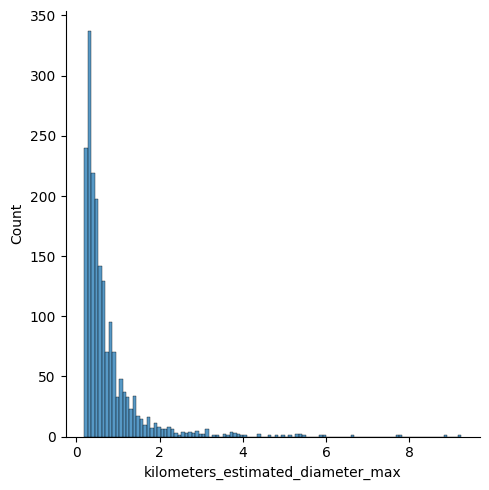

In [297]:
sns.displot(data = df_united[df_united['is_potentially_hazardous_asteroid'] == True]['kilometers_estimated_diameter_max'])
plt.show()

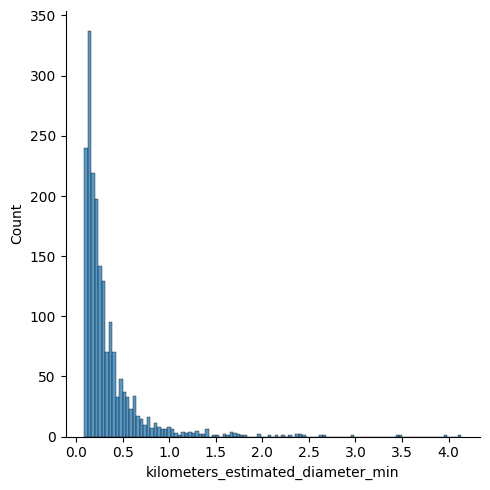

In [298]:
sns.displot(data = df_united[df_united['is_potentially_hazardous_asteroid'] == True]['kilometers_estimated_diameter_min'])
plt.show()

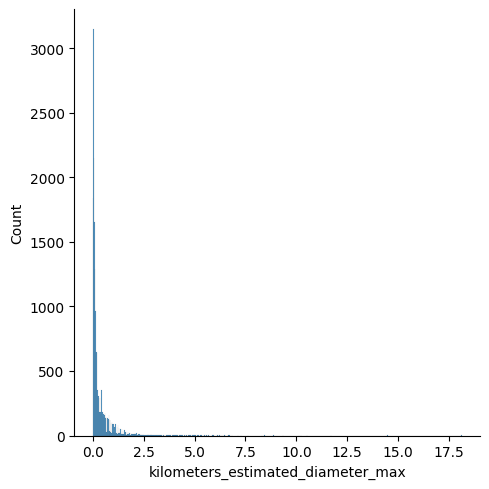

In [299]:
sns.displot(data = df_united[df_united['is_potentially_hazardous_asteroid'] == False]['kilometers_estimated_diameter_max'])
plt.show()

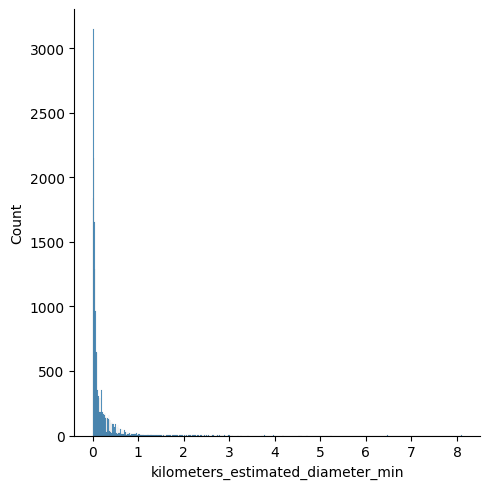

In [300]:
sns.displot(data = df_united[df_united['is_potentially_hazardous_asteroid'] == False]['kilometers_estimated_diameter_min'])
plt.show()

#### Observaciones:

Corroboramos que la diferencia entre ambas columnas es muy pequeña, por lo que vamos a condensarlas en una sola columna y así sacar la correlación que había presente

<br>

### Outliers

Text(0.5, 1.0, 'aphelion_distance')

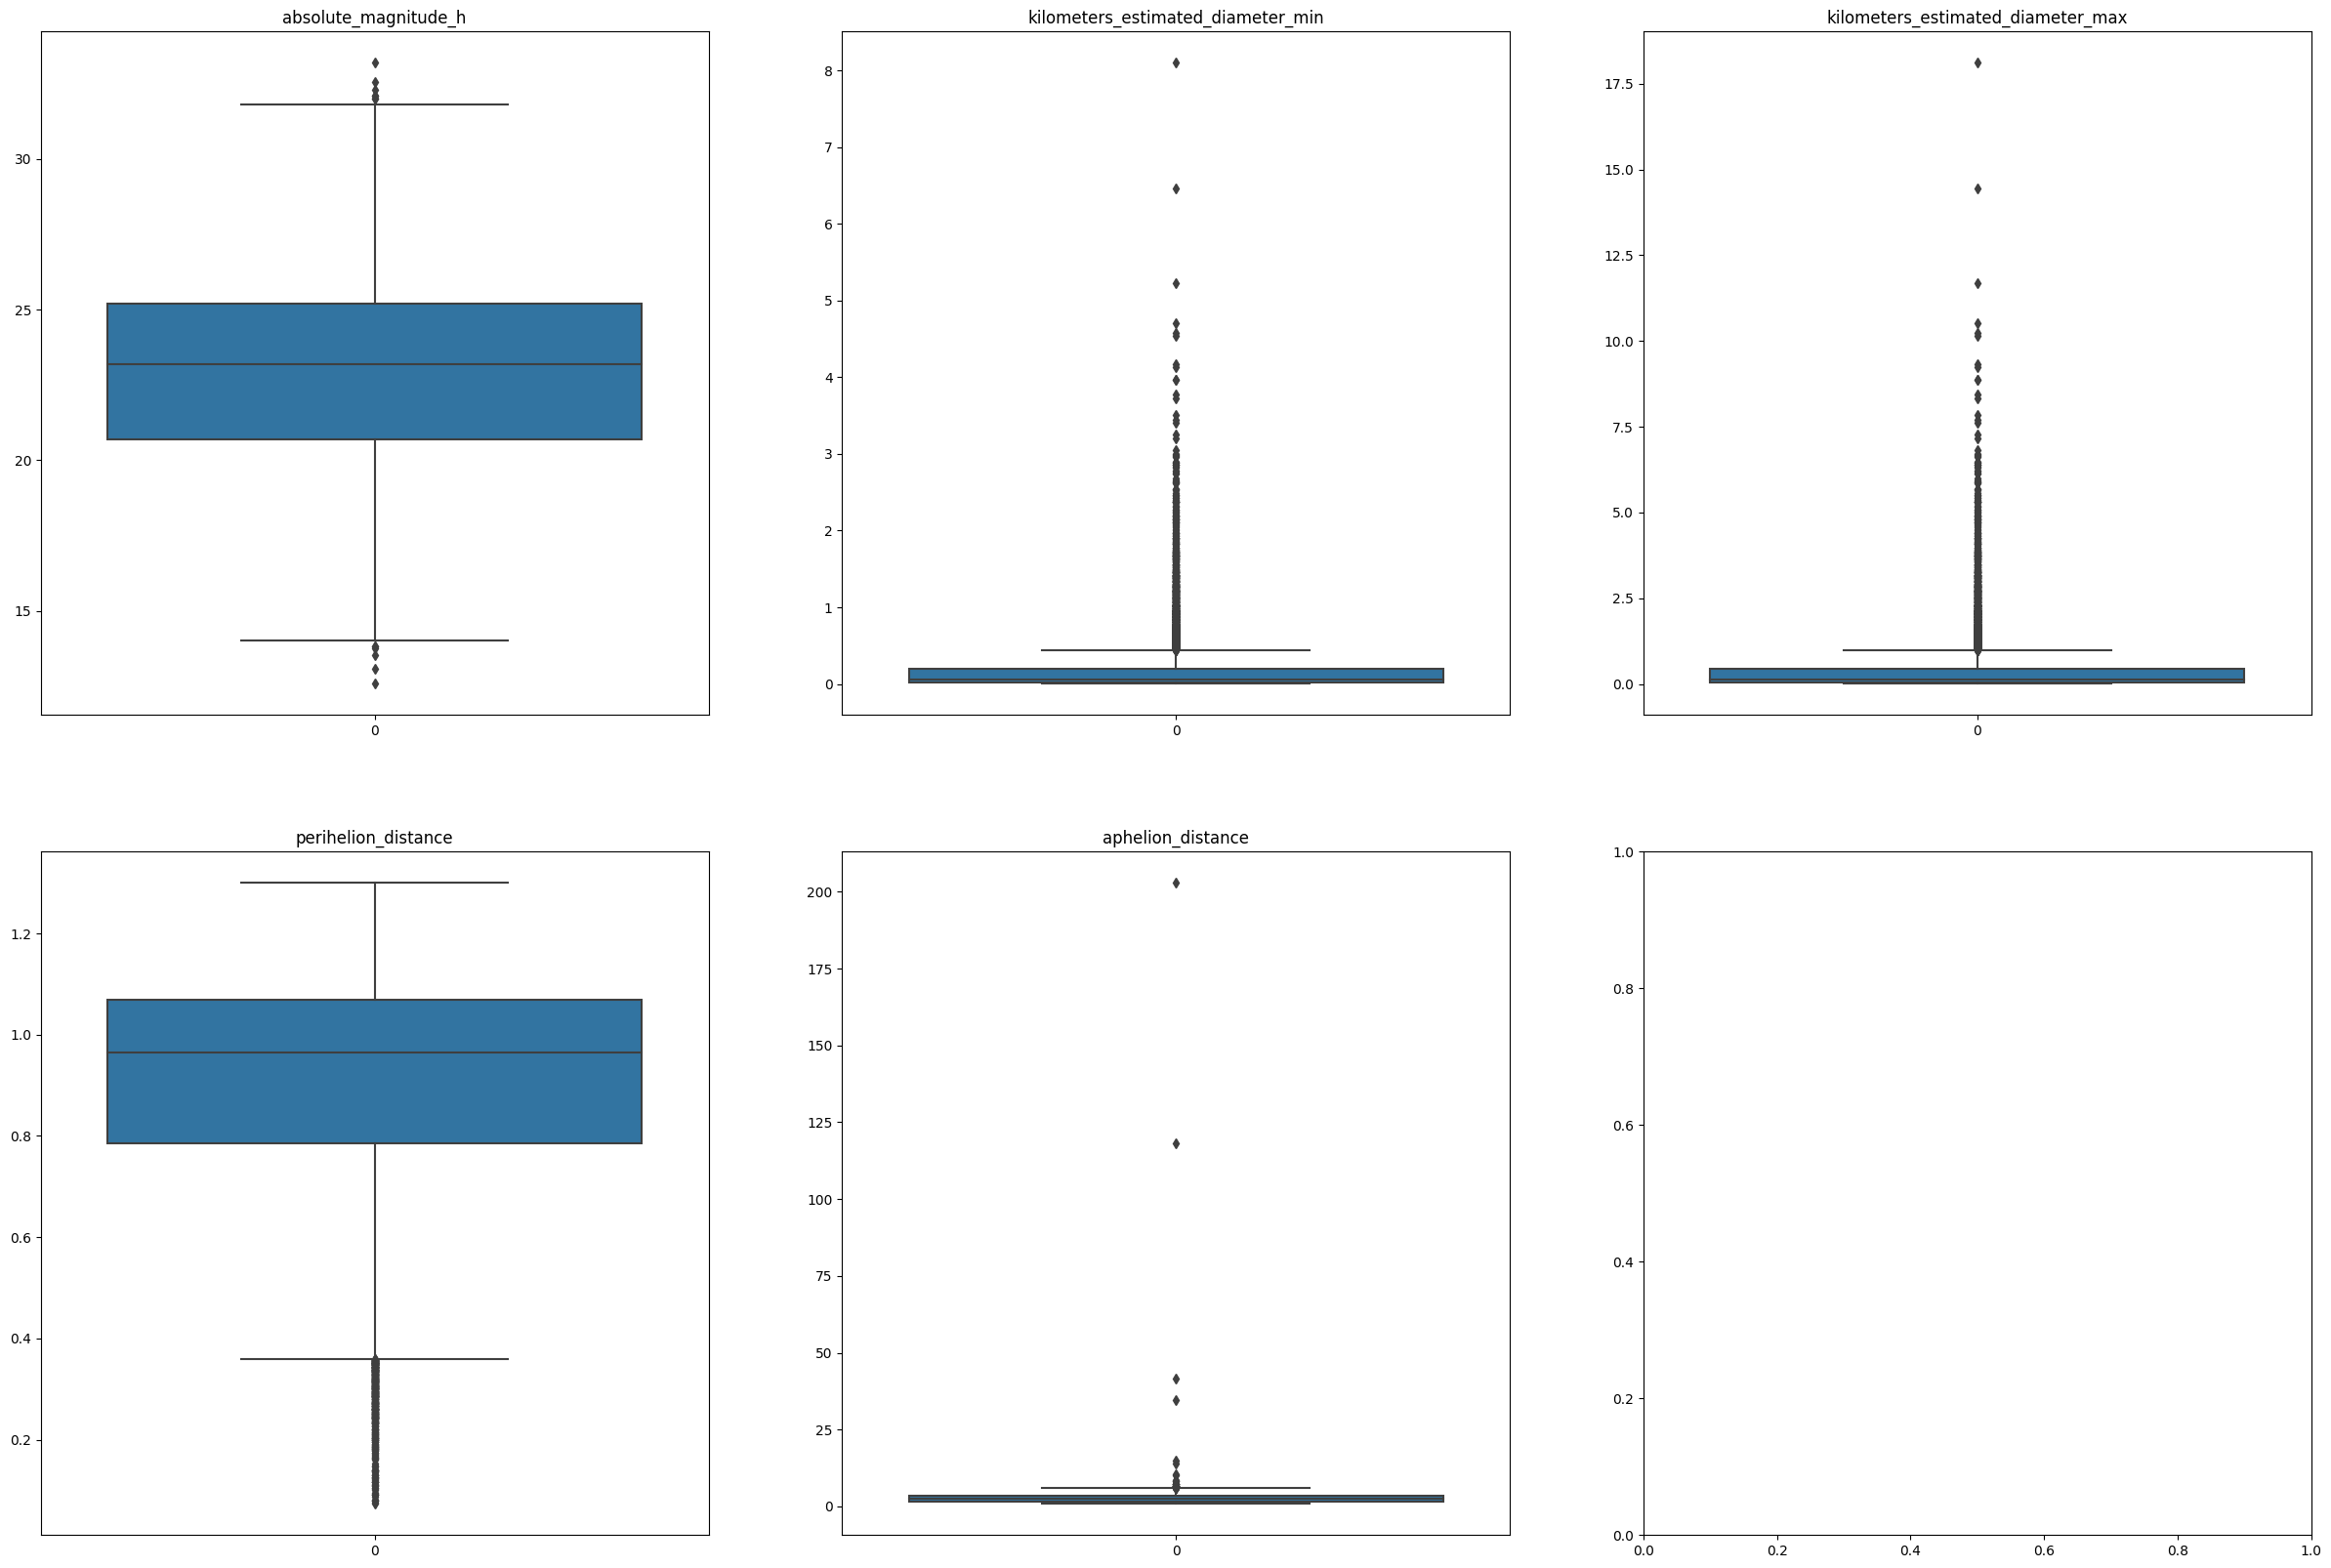

In [303]:
fig, axes = plt.subplots(2,3,figsize=(30, 20))

# ['absolute_magnitude_h', 'kilometers_estimated_diameter_min', 'kilometers_estimated_diameter_max', 'perihelion_distance', 'aphelion_distance']

sns.boxplot(data=df_united['absolute_magnitude_h'],ax=axes[0][0])
axes[0][0].set_title('absolute_magnitude_h')

sns.boxplot(data=df_united['kilometers_estimated_diameter_min'],ax=axes[0][1])
axes[0][1].set_title('kilometers_estimated_diameter_min')

sns.boxplot(data=df_united['kilometers_estimated_diameter_max'],ax=axes[0][2])
axes[0][2].set_title('kilometers_estimated_diameter_max')

sns.boxplot(data=df_united['perihelion_distance'],ax=axes[1][0])
axes[1][0].set_title('perihelion_distance')

sns.boxplot(data=df_united['aphelion_distance'],ax=axes[1][1])
axes[1][1].set_title('aphelion_distance')

Solo analizamos las columnas 'absolute_magnitude_h' y 'perihelion_distance', ya que las demás presentan estas gráficas debido a sus distruciones con marcado sesgo.

In [304]:
# 'absolute_magnitude_h'

stat = df_united['absolute_magnitude_h'].describe()
IQR = stat['75%'] - stat['25%']
superior = stat['75%'] + IQR*1.5
inferior = stat['25%'] - IQR*1.5

df_united[(df_united['absolute_magnitude_h'] < inferior) & (df_united['absolute_magnitude_h'] > superior)].value_counts

<bound method DataFrame.value_counts of Empty DataFrame
Columns: [id, name, absolute_magnitude_h, is_sentry_object, kilometers_estimated_diameter_min, kilometers_estimated_diameter_max, orbit_id, orbit_class_type, perihelion_distance, aphelion_distance, first_observation_date, last_observation_date, orbit_class_description, is_potentially_hazardous_asteroid]
Index: []>

In [305]:
# 'perihelion_distance'

stat = df_united['perihelion_distance'].describe()
IQR = stat['75%'] - stat['25%']
superior = stat['75%'] + IQR*1.5
inferior = stat['25%'] - IQR*1.5

df_united[(df_united['perihelion_distance'] < inferior) & (df_united['perihelion_distance'] > superior)].value_counts

<bound method DataFrame.value_counts of Empty DataFrame
Columns: [id, name, absolute_magnitude_h, is_sentry_object, kilometers_estimated_diameter_min, kilometers_estimated_diameter_max, orbit_id, orbit_class_type, perihelion_distance, aphelion_distance, first_observation_date, last_observation_date, orbit_class_description, is_potentially_hazardous_asteroid]
Index: []>

Observaciones:

En los casos de 'kilometers_estimated_diameter_min', 'kilometers_estimated_diameter_max' y 'aphelion_distance', debido a que las distribuciones presentan un gran sesgo positivo, por ello los boxplots se presentan de esta forma, lo que significa que en principio no son outliers. 


Para las variables 'absolute_magnitude_h' y 'perihelion_distance' no existen outliers que se requieran eliminar

_________________________

## Transformación de datos  

Para un paneo general, puntualizamos que transformaciones vamos a realizar:



- Vamos a convertir a datatime dtype a las columnas 'first_observation_date' y 'last_observation_date'

- Las columnas 'is_potentially_hazardous_asteroid' y 'is_sentry_object' se encodean en 0 y 1

- La columna 'orbit_class_type' puede encodearse en 0, 1, 2 y 3 por tener 4 categorías diferentes

- La columnas 'orbit_id' podrían pasarse a tipo numérico, verificarlo

- Se analiza la columna 'orbit_class_description' si es posible encodearla numéricamente

- Las columnas 'kilometers_estimated_diameter_min' y 'kilometers_estimated_diameter_max' se pasan a metros y las promediamos para quedarnos con una sola

- Se crea una nueva variable de volumen (volume (m^3))

- Las variables continuas que presentan sesgo se transforman (BoxCox)

- Estandarizar todas las variables continuas (MinMaxScaler)


Comentario: todo se va a aplicar en primera instancia a df_raw, luego se crea el Pipeline para pasar las divisiones desde el app-pipeline.py (train, valid y test)

In [306]:
# df_raw['first_observation_date'] = pd.to_datetime(df_raw['first_observation_date']) - Error: Unknown string format: 2008-??-??

# Hay un valor en la columna 'first_observation_date' que vale '2008-??-??', por lo cual no es posible 
# convertirlo a datetime tipo de dato. Entonces procedemos a borrar ese registro

In [307]:
df_raw[df_raw['first_observation_date'] == '2008-??-??']

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
20702,3843794,(2019 RN1),20.6,False,False,0.20163,0.450858,MPO508629,AMO,1.077174,1.865083,2008-??-??,2019-09-06,Near-Earth asteroid orbits similar to that of ...



El registro a eliminar corresponde a la categoria mayoritaria de la columna 'is_potentially_hazardous_asteroid' 

In [309]:
df_raw = df_raw.drop(df_raw[df_raw['first_observation_date'] == '2008-??-??'].index[0])

# Transformando a datetime tipo de dato

df_raw['first_observation_date'] = pd.to_datetime(df_raw['first_observation_date'])
df_raw['last_observation_date'] = pd.to_datetime(df_raw['last_observation_date'])

# Transformacion a 0 y 1 de las columnas 'is_potentially_hazardous_asteroid' y 'is_sentry_object'

df_raw['is_potentially_hazardous_asteroid'] = pd.Categorical(df_raw['is_potentially_hazardous_asteroid'])
df_raw['is_potentially_hazardous_asteroid'] = df_raw['is_potentially_hazardous_asteroid'].cat.codes

df_raw['is_sentry_object'] = pd.Categorical(df_raw['is_sentry_object'])
df_raw['is_sentry_object'] = df_raw['is_sentry_object'].cat.codes

# Transformando las categorias de 'orbit_class_type' a 0, 1, 2 y 3

df_raw['orbit_class_type'] = pd.Categorical(df_raw['orbit_class_type'])
df_raw['orbit_class_type'] = df_raw['orbit_class_type'].cat.codes

Verificando valores de la columna 'orbit_id' para analizar

In [312]:
df_raw['orbit_id'].sample(10)

10846    11
7899     21
15229     6
6380     40
15535    17
1610     70
10859     6
8162      7
17419     9
16586     5
Name: orbit_id, dtype: object

Se chequea si todos los valores de esta columna son numéricos

In [313]:
df_raw[np.logical_not(df_raw['orbit_id'].str.isnumeric())]

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,kilometers_estimated_diameter_min,kilometers_estimated_diameter_max,orbit_id,orbit_class_type,perihelion_distance,aphelion_distance,first_observation_date,last_observation_date,orbit_class_description
10055,3645194,(2013 NE24),27.3,0,0,0.009216,0.020608,E2021-CI3,1,0.944657,4.634736,2013-07-14,2013-07-15,Near-Earth asteroid orbits which cross the Ear...
14813,3759689,(2016 RM41),25.3,0,0,0.023150,0.051765,MPO392510,0,1.050360,4.923787,2016-09-10,2016-09-11,Near-Earth asteroid orbits similar to that of ...


El dataset contiene solamente dos valores no numericos en la columna orbit_id, y ademas pertenecen a la categoria mayoritaria de nuestro target, por lo que podemos eliminarlas

In [314]:
df_raw = df_raw.drop(df_raw[df_raw['orbit_id'] == 'E2021-CI3'].index[0])
df_raw = df_raw.drop(df_raw[df_raw['orbit_id'] == 'MPO392510'].index[0])

df_raw['orbit_id'] = pd.to_numeric(df_raw['orbit_id'])

In [315]:
# Terminar de transformar a cateorica las columnas 'name' y 'orbit_class_description'

df_raw['name'] = pd.Categorical(df_raw['name'])
df_raw['orbit_class_description'] = pd.Categorical(df_raw['orbit_class_description'])

In [316]:
# Vamos a hacer un analisis de la columna 'orbit_class_description' para 
# observar las descripciones y evaluar si pueden haber aportes valiosos de informacion

df_raw['orbit_class_description'].unique()

['Near-Earth asteroid orbits which cross the Ea..., 'Near-Earth asteroid orbits similar to that of..., 'Near-Earth asteroid orbits similar to that of..., 'An asteroid orbit contained entirely within t...]
Categories (4, object): ['An asteroid orbit contained entirely within t..., 'Near-Earth asteroid orbits similar to that of..., 'Near-Earth asteroid orbits similar to that of..., 'Near-Earth asteroid orbits which cross the Ea...]

In [317]:
# La columna solo contiene 4 tipos de descripciones, entonces vamos a encodearla

df_raw['orbit_class_description'] = df_raw['orbit_class_description'].cat.codes

In [318]:
# Procedemos a transformar las variables que estan en kilometros a metros

df_raw['kilometers_estimated_diameter_min'] = df_raw['kilometers_estimated_diameter_min']*1000
df_raw['kilometers_estimated_diameter_max'] = df_raw['kilometers_estimated_diameter_max']*1000

df_raw.rename(columns = {'kilometers_estimated_diameter_min':'meters_estimated_diameter_min'}, inplace = True)
df_raw.rename(columns = {'kilometers_estimated_diameter_max':'meters_estimated_diameter_max'}, inplace = True)

Vamos a introducir una nueva variable, calculada a partir del diámetro. Esta será el volumen del cuerpo, aproximando su forma a un elipsoide  
(volumen_elipsoide = (4/3) * $\pi$ * a * b * c) 

Aproximamos a y b a los valores de 'meters_estimated_diameter_min' y c a los valores de 'meters_estimated_diameter_max'

In [319]:
import math

df_raw['volume (m^3)'] = (4/3)*math.pi*((df_raw['meters_estimated_diameter_min']/2)**2)*(df_raw['meters_estimated_diameter_max']/2)

Luego de haber calculado la columna de volumen, vamos a eliminar la columna meters_estimated_diameter_min y en el lugar de meters_estimated_diameter_max poner los valores promediados entre ambas columnas

In [321]:
mean = (df_raw['meters_estimated_diameter_max'] + df_raw['meters_estimated_diameter_min'])/2

df_raw.drop(columns = ['meters_estimated_diameter_min'], inplace = True)
df_raw.rename(columns = {'meters_estimated_diameter_max':'meters_estimated_diameter'}, inplace = True)
df_raw['meters_estimated_diameter'] = mean

Vamos a aplicar BoxCox a todas las variables continuas no negativas que tienen sesgo, ya que al no presentar una distribucion aproximadamente normal esto puede afectar a la aplicacion de los algoritmos 

Se aplica a las variables 'meters_estimated_diameter', 'perihelion_distance', 'aphelion_distance', 'volume (m^3)'

In [322]:
df_raw['meters_estimated_diameter'], lambda1 = boxcox(df_raw['meters_estimated_diameter'])
df_raw['perihelion_distance'], lambda2 = boxcox(df_raw['perihelion_distance'])
df_raw['aphelion_distance'], lambda3 = boxcox(df_raw['aphelion_distance'])
df_raw['volume (m^3)'], lambda4 = boxcox(df_raw['volume (m^3)'])

Vamos a aplicar estandarizacion a las variables continuas (MinMaxScaler), estas son 'absolute_magnitude_h', 'meters_estimated_diameter', 'perihelion_distance' y 'aphelion_distance'

In [323]:
from sklearn.preprocessing import MinMaxScaler

X_train_scaler = pd.read_csv('../data/processed/X_train_scaler.csv')

scaler = MinMaxScaler()
scaler.fit(X_train_scaler[['absolute_magnitude_h', 'meters_estimated_diameter', 'perihelion_distance', 'aphelion_distance', 'volume (m^3)']])

df_raw[['absolute_magnitude_h', 'meters_estimated_diameter', 'perihelion_distance', 'aphelion_distance', 'volume (m^3)']] = scaler.transform(df_raw[['absolute_magnitude_h', 'meters_estimated_diameter', 'perihelion_distance', 'aphelion_distance', 'volume (m^3)']])

Las columnas 'absolute_magnitude_h', 'meters_estimated_diameter', 'volume (m^3)' presentan valores faltantes. Se procede a llenarlos con las mediana de su columna correspondiente solo en el dataset de entrenamiento

In [324]:
# recordar que esto es a modo de ilustrar el proceso, desde el app se aplica solo a X_train y X_valid

imputer_median1 = SimpleImputer(strategy='median', missing_values=np.nan)
df_raw['absolute_magnitude_h'] = imputer_median1.fit_transform(df_raw[['absolute_magnitude_h']])

imputer_median2 = SimpleImputer(strategy='median', missing_values=np.nan)
df_raw['meters_estimated_diameter'] = imputer_median2.fit_transform(df_raw[['meters_estimated_diameter']])

imputer_median3 = SimpleImputer(strategy='median', missing_values=np.nan)
df_raw['volume (m^3)'] = imputer_median3.fit_transform(df_raw[['volume (m^3)']])

In [2]:
# importacion de datos ya tratados desde el app

X_train = pd.read_csv('../data/processed/X_train.csv')
X_valid = pd.read_csv('../data/processed/X_valid.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv')
y_valid = pd.read_csv('../data/processed/y_valid.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

df_processed = pd.read_csv('../data/processed/df_processed.csv') # para comparar con lo realizado en el explore

In [3]:
arr1 = [X_train, X_valid, X_test, y_train, y_valid, y_test, df_processed]
arr2 = [X_train, X_valid, X_test, df_processed]

for data in arr1:
    data.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0'], inplace = True)

for data in arr2:
    data.drop(columns = ['name', 'id', 'orbit_id', 'first_observation_date', 'last_observation_date'], inplace = True)

Las variables 'name', 'id', 'orbit_id', 'first_observation_date', 'last_observation_date' se sacaron de los datasets ya que no tienen valor predictivo para nuestros algoritmos

_______________________________________________

## Problema del dataset desbalanceado

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV

In [6]:
# Funciones

def modelAnalysis(clf,y_pred):
    sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(y_pred)), annot= True , fmt='d')
    plt.show()
    print(f'Accuraccy score: {accuracy_score(np.ravel(y_valid),np.ravel(y_pred))}\n')
    print(f'classification report: \n{classification_report(np.ravel(y_valid),np.ravel(y_pred))}')

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(clf, X_united, np.ravel(y_united), scoring='roc_auc', cv=cv, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % np.mean(scores))

Primero entrenaremos los modelos con la proporción original del dataset, de esta manera tendremos un punto de referencia a la hora de evaluar las diferentes tecnicas de balanceo a estudiar.

In [8]:
X_united = pd.concat([X_train, X_valid])
y_united = pd.concat([y_train, y_valid])

<br>

Comentario: para evaluar la performance de los modelos, nos centramos en el parámetro ´recall´, y se puede ver reflejado en la matriz de confusión en el cuadrante de abajo a la derecha (correspondientes a los falsos negativos). Esto es porque nos importa predecir correctamente que un cuerpo que supone un riesgo de impacto, sino estaríamos pasando por alto un peligro que puede llegar a ser catastrófico.

### Logistic Regression sin balanceo previo

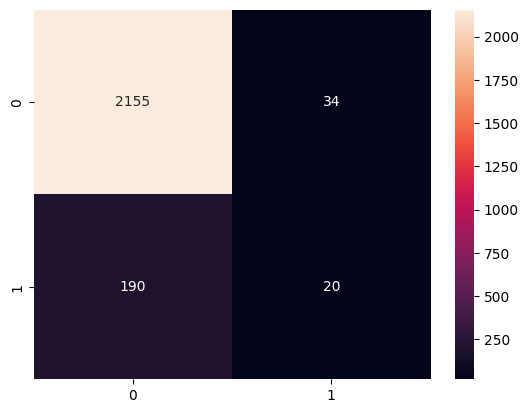

Accuraccy score: 0.9066277615673197

classification report: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2189
           1       0.37      0.10      0.15       210

    accuracy                           0.91      2399
   macro avg       0.64      0.54      0.55      2399
weighted avg       0.87      0.91      0.88      2399

Mean ROC AUC: 0.890


In [15]:
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train,np.ravel(y_train))
y_pred_lr = clf_lr.predict(X_valid)

modelAnalysis(clf_lr,y_pred_lr)

Podemos ver evidentemente que es necesario trabajar en reducir la proporción de falsos negativos, esto es los datos que están registrados como peligrosos pero el algoritmo los clasifica como no peligrosos

#### Elegimos las features más imporantes con RFECV

In [18]:
rfecv_lr = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='roc_auc')
rfecv_lr.fit(X_train, np.ravel(y_train))

RFECV(cv=10, estimator=LogisticRegression(), scoring='roc_auc')

In [332]:
print("Optimal number of features: %d" % rfecv_lr.n_features_)
print('Selected features: %s' % list(X_train.columns[rfecv_lr.support_]))
print(f'{rfecv_lr.grid_scores_}')
print(f'{X_train.columns}')

Optimal number of features: 4
Selected features: ['absolute_magnitude_h', 'is_sentry_object', 'orbit_class_type', 'orbit_class_description']
[[0.81246691 0.80846351 0.80545071 0.83147152 0.82919351 0.80582735
  0.83271669 0.82516919 0.80856096 0.80519099]
 [0.87727625 0.87423954 0.88829927 0.89220143 0.89869061 0.89403097
  0.89737749 0.89472745 0.8700134  0.86791656]
 [0.87675192 0.88462038 0.88889363 0.89194152 0.89948222 0.89510797
  0.89535599 0.90214415 0.87016378 0.86980662]
 [0.88011655 0.88538212 0.89322837 0.90177043 0.89992899 0.89567195
  0.89788711 0.90244313 0.87297323 0.87040132]
 [0.87965882 0.88538212 0.89322496 0.90195559 0.89926818 0.89567195
  0.89788711 0.90244313 0.87296981 0.87040132]
 [0.87968273 0.88452302 0.89322496 0.90176193 0.89927498 0.89556493
  0.8978939  0.90246351 0.87296981 0.87014669]
 [0.87967932 0.88452644 0.89309686 0.90177552 0.89928857 0.89556493
  0.89797035 0.90263508 0.87309627 0.87015353]
 [0.87964516 0.88452986 0.89348286 0.90177552 0.899261

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


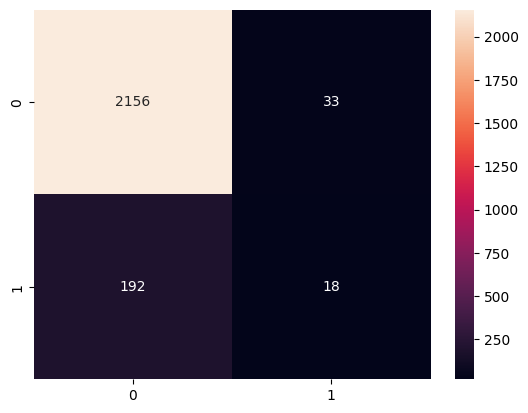

Accuraccy score: 0.9062109212171738

classification report: 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2189
           1       0.35      0.09      0.14       210

    accuracy                           0.91      2399
   macro avg       0.64      0.54      0.54      2399
weighted avg       0.87      0.91      0.88      2399

Mean ROC AUC: 0.890


In [19]:
clf_lr_rfecv = LogisticRegression(max_iter=1000)
clf_lr_rfecv.fit(X_train[['absolute_magnitude_h', 'is_sentry_object', 'orbit_class_type', 'orbit_class_description']],np.ravel(y_train))
y_pred_rfecv = clf_lr_rfecv.predict(X_valid[['absolute_magnitude_h', 'is_sentry_object', 'orbit_class_type', 'orbit_class_description']])

modelAnalysis(clf_lr_rfecv,y_pred_rfecv)

Se puede apreciar que las variables seleccionadas por el método no reflejan una mejora en los resultados

### Random Forest sin balanceo previo

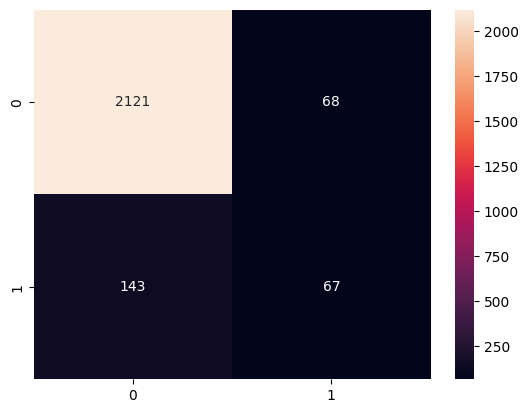

Accuraccy score: 0.9120466861192164

classification report: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      2189
           1       0.50      0.32      0.39       210

    accuracy                           0.91      2399
   macro avg       0.72      0.64      0.67      2399
weighted avg       0.90      0.91      0.90      2399

Mean ROC AUC: 0.935


In [9]:
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train,np.ravel(y_train))
y_pred_rf = clf_rf.predict(X_valid)

modelAnalysis(clf_rf, y_pred_rf)

Aquí podemos ver lo mismo que con Logistic Regression, es necesario bajar los falsos negativos

#### Elegimos las features más imporantes con RFECV

In [20]:
rfecv_rf = RFECV(estimator=RandomForestClassifier(), step=1, cv=10, scoring='roc_auc')
rfecv_rf.fit(X_train, np.ravel(y_train))

RFECV(cv=10, estimator=RandomForestClassifier(), scoring='roc_auc')

In [336]:
print("Optimal number of features: %d" % rfecv_rf.n_features_)
print('Selected features: %s' % list(X_train.columns[rfecv_rf.support_]))
print(f'{rfecv_rf.grid_scores_}')
print(f'{X_train.columns}')

Optimal number of features: 6
Selected features: ['absolute_magnitude_h', 'meters_estimated_diameter', 'orbit_class_type', 'perihelion_distance', 'aphelion_distance', 'orbit_class_description']
[[0.62037363 0.6497228  0.58176573 0.59815823 0.61300351 0.6228477
  0.61039594 0.59527207 0.5962715  0.57358571]
 [0.92642382 0.92373724 0.92020693 0.92768639 0.91920798 0.92600124
  0.91374653 0.92364339 0.92983724 0.90575527]
 [0.93178162 0.93018128 0.93551175 0.94656787 0.93240208 0.94036747
  0.93282847 0.92558165 0.93585261 0.92527274]
 [0.93232303 0.93188922 0.9351787  0.94767884 0.92976564 0.94076158
  0.93128771 0.92598765 0.93685232 0.92321863]
 [0.92994559 0.92923679 0.93854675 0.9481392  0.93260084 0.9384479
  0.93279279 0.92466943 0.93654814 0.91856868]
 [0.93162107 0.92998999 0.93688664 0.9481443  0.93163425 0.93854133
  0.93303571 0.92797517 0.94001723 0.92271792]
 [0.93150835 0.93282004 0.93481833 0.94751067 0.93257026 0.93753907
  0.93330072 0.92838457 0.93656523 0.9223505 ]
 [0

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


El resultado de selección de features son todas las variables que ya están en el dataset originalmente

Los datos en principio dan bien, pero se puede apreciar el peso que tiene en la precision de la categoria 1 el tema de que el dataset sea desbalanceado

<br>

Ahora aplicaremos diferentes tecnicas de balanceo al dataset, relativas a Random Forest y Logistic Regression. 

## Relativo a Logistic Regression

In [12]:
from collections import Counter
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

#### 1) Penalizacion

Utilizaremos un parámetro adicional en el modelo de LogisticRegression en donde indicamos weight = “balanced” y con esto el algoritmo se encargará de equilibrar a la clase minoritaria durante el entrenamiento.

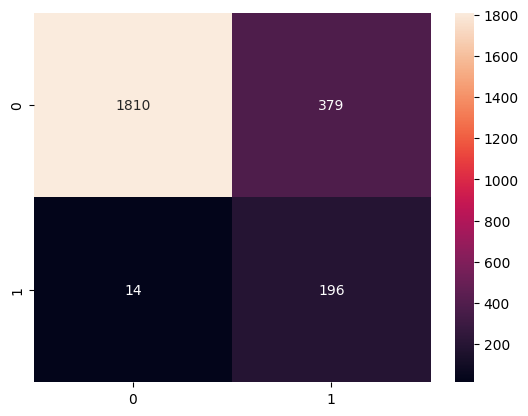

Accuraccy score: 0.8361817423926636

classification report: 
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      2189
           1       0.34      0.93      0.50       210

    accuracy                           0.84      2399
   macro avg       0.67      0.88      0.70      2399
weighted avg       0.94      0.84      0.87      2399

Mean ROC AUC: 0.895


In [10]:
lr_pen = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced", max_iter=10000)
lr_pen.fit(X_train, np.ravel(y_train))

pred_y_lr_pen = lr_pen.predict(X_valid)
modelAnalysis(lr_pen, pred_y_lr_pen)

Podemos apreciar una mejora importante respecto a los falsos negativos, y el recall en la categoría de positivo para peligro es muy bueno

#### 2) Subsampling en la clase mayoritaria

Podemos eliminar muestras de la clase mayoritaria para reducirla e intentar equilibrar la situación. Tiene como “peligroso” que podemos prescindir de muestras importantes, que brindan información y por lo tanto empeorar el modelo.

Distribution before resampling Counter({0: 17523, 1: 1675})
Distribution after resampling Counter({0: 5583, 1: 1675})


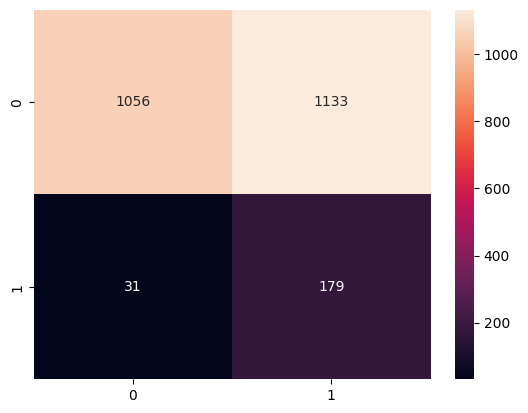

Accuraccy score: 0.5147978324301793

classification report: 
              precision    recall  f1-score   support

           0       0.97      0.48      0.64      2189
           1       0.14      0.85      0.24       210

    accuracy                           0.51      2399
   macro avg       0.55      0.67      0.44      2399
weighted avg       0.90      0.51      0.61      2399

Mean ROC AUC: 0.890


In [13]:
us = NearMiss(sampling_strategy=0.3, n_neighbors=3, version=2)
X_train_res, y_train_res = us.fit_resample(X_train, np.ravel(y_train))
 
print(f"Distribution before resampling {Counter(np.ravel(y_train))}")
print(f"Distribution after resampling {Counter(y_train_res)}")
 
lr_us = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
lr_us.fit(X_train_res, np.ravel(y_train_res))
pred_y_lr_us = lr_us.predict(X_valid)
modelAnalysis(lr_us, pred_y_lr_us)

El recall de la categoría positiva es bueno, pero ha afectado al de la categoría de negativos

#### 3) Oversampling de la clase minoritaria

Podemos intentar crear muestras sintéticas que intentan seguir la tendencia del grupo minoritario. Lo peligroso de crear muestras sintéticas es que podemos alterar la distribución “natural” de esa clase y confundir al modelo en su clasificación.

Distribution before resampling Counter({0: 17523, 1: 1675})
Distribution after resampling Counter({0: 17523, 1: 5256})


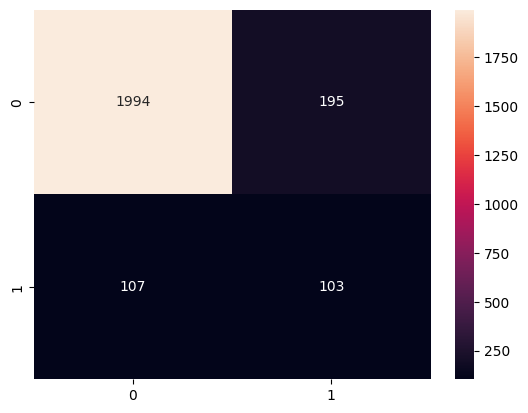

Accuraccy score: 0.8741142142559399

classification report: 
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2189
           1       0.35      0.49      0.41       210

    accuracy                           0.87      2399
   macro avg       0.65      0.70      0.67      2399
weighted avg       0.90      0.87      0.88      2399

Mean ROC AUC: 0.890


In [14]:
os = RandomOverSampler(sampling_strategy=0.3)
X_train_res, y_train_res = os.fit_resample(X_train, np.ravel(y_train))
 
print(f"Distribution before resampling {Counter(np.ravel(y_train))}")
print(f"Distribution after resampling {Counter(y_train_res)}")
 
lr_os = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
lr_os.fit(X_train_res, np.ravel(y_train_res))
pred_y_lr_os = lr_os.predict(X_valid)
modelAnalysis(lr_os, pred_y_lr_os)

Este algoritmo podemos apreciar que no fue muy bueno en solucionar nuestra problemática, ya que solamente trató de igualar los falsos negativos con los positivos correctamente acertados

#### 4) Smote-Tomek

Probamos una técnica muy usada que consiste en aplicar en simultáneo un algoritmo de subsampling y otro de oversampling a la vez al dataset. En este caso usaremos SMOTE para oversampling; busca puntos vecinos cercanos y agrega puntos “en linea recta” entre ellos. Y usaremos Tomek para undersampling que quita los de distinta clase que sean nearest neighbor y deja ver mejor el decisión boundary (la zona limítrofe de nuestras clases).

Distribution before resampling Counter({0: 17523, 1: 1675})
Distribution after resampling Counter({0: 17284, 1: 8522})


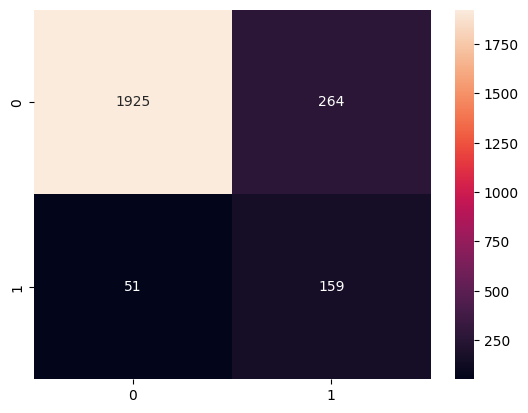

Accuraccy score: 0.8686952897040433

classification report: 
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      2189
           1       0.38      0.76      0.50       210

    accuracy                           0.87      2399
   macro avg       0.68      0.82      0.71      2399
weighted avg       0.92      0.87      0.89      2399

Mean ROC AUC: 0.890


In [16]:
os_us = SMOTETomek(sampling_strategy=0.5)
X_train_res, y_train_res = os_us.fit_resample(X_train, np.ravel(y_train))
 
print ("Distribution before resampling {}".format(Counter(np.ravel(y_train))))
print ("Distribution after resampling {}".format(Counter(y_train_res)))

lr_st = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg")
lr_st.fit(X_train_res, np.ravel(y_train_res))
pred_y_lr_st = lr_st.predict(X_valid)
modelAnalysis(lr_st, pred_y_lr_st)

Este algoritmo se comportó bastante bien respecto a los anteriores pero igual el de penalización hasta ahora ha sido el mejor

#### Comparacion de modelos

Text(0.5, 1.0, 'Con SmoteTomek')

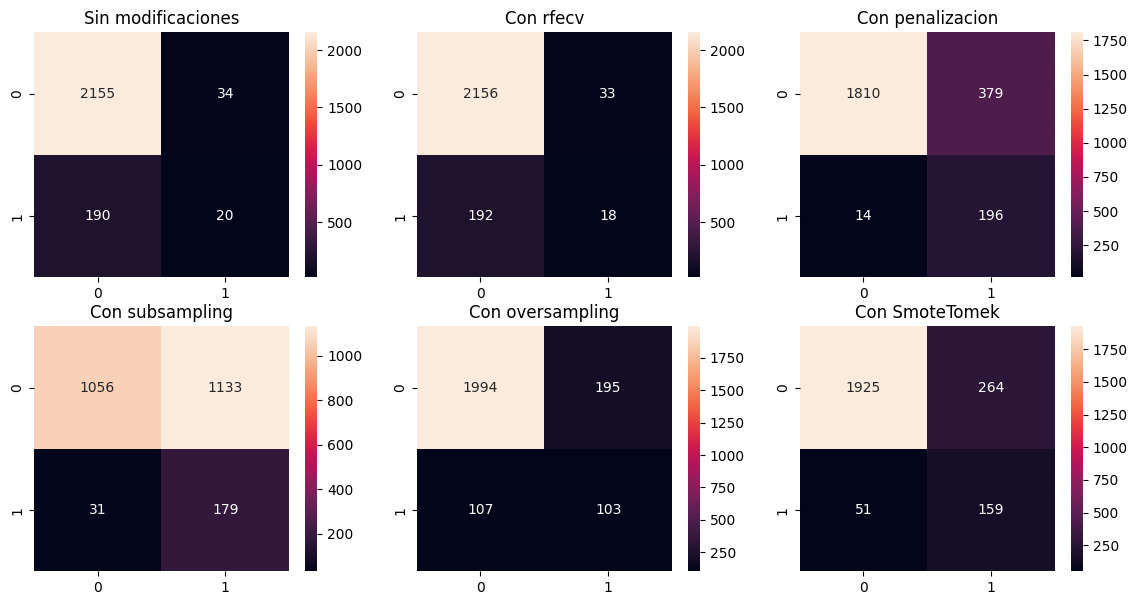

In [21]:
fig, ax = plt.subplots(2,3,figsize=(14,7))

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(y_pred_lr)), annot= True , fmt='d', ax=ax[0][0])
ax[0][0].set_title('Sin modificaciones')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(y_pred_rfecv)), annot= True , fmt='d', ax=ax[0][1])
ax[0][1].set_title('Con rfecv')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(pred_y_lr_pen)), annot= True , fmt='d', ax=ax[0][2])
ax[0][2].set_title('Con penalizacion')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(pred_y_lr_us)), annot= True , fmt='d', ax=ax[1][0])
ax[1][0].set_title('Con subsampling')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(pred_y_lr_os)), annot= True , fmt='d', ax=ax[1][1])
ax[1][1].set_title('Con oversampling')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(pred_y_lr_st)), annot= True , fmt='d', ax=ax[1][2])
ax[1][2].set_title('Con SmoteTomek')

Como dijimos anteriormente, el algoritmo de penalización fue el que mejor performance ha presentado

## Relativo a Random Forest

In [22]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

#### 1) Class Weighting

Una técnica simple para modificar un DecisionTree para una clasificación desbalanceada es cambiar el peso que cada clase tiene cuando se calcula el valor de impuridad para un punto de split dado.

La impuridad mide que tan mezclados están los grupos de las muestras dadas en el dataset de entrenamiento y comúnmente se mide con Gini o Entropy. El calculo puede sesgarse para que se favorezca a la clase minoritaria, permitiendo algunos falsos positivos para la clase mayoritaria.

Esta modificación en RandomForest se denomina Weighted RandomForest. Esto se puede lograr estableciendo el argumento class_weight en el modelo como 'balanced'.

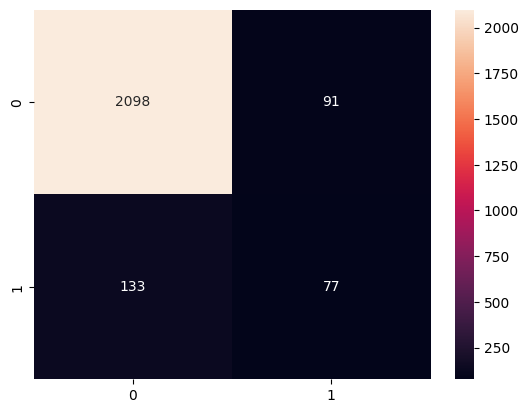

Accuraccy score: 0.9066277615673197

classification report: 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2189
           1       0.46      0.37      0.41       210

    accuracy                           0.91      2399
   macro avg       0.70      0.66      0.68      2399
weighted avg       0.90      0.91      0.90      2399

Mean ROC AUC: 0.920


In [23]:
clf_cw = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=42)
clf_cw.fit(X_train,np.ravel(y_train))
y_pred_clf_cw = clf_cw.predict(X_valid)

modelAnalysis(clf_cw, y_pred_clf_cw)

Este algoritmo no fue muy satisfactorio en reducir la cantidad de falsos negativos

#### 2) Bootstrap Class Weighting

Dado que cada DecisionTree es construido desde una muestra aleatoria con reposición, la distribución de clases en la muestra va a ser diferente para cada árbol. Por ello, sería interesante cambiar el peso de las clases basandose en la distribución de cada muestra con reposición, en lugar de todo el dataset de entrenamiento.

Esto puede lograrse estableciendo el argumento class_weight como 'balanced_subsample'.

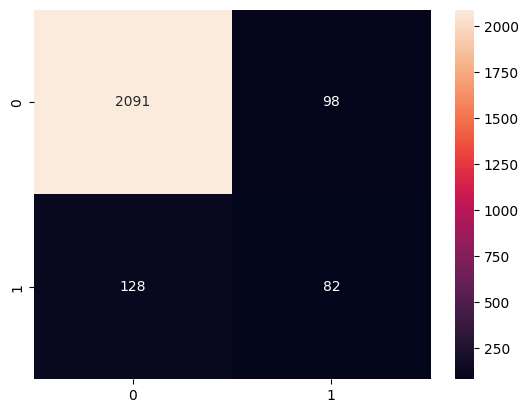

Accuraccy score: 0.905794080867028

classification report: 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2189
           1       0.46      0.39      0.42       210

    accuracy                           0.91      2399
   macro avg       0.70      0.67      0.68      2399
weighted avg       0.90      0.91      0.90      2399

Mean ROC AUC: 0.920


In [24]:
clf_bc = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample', random_state=42)
clf_bc.fit(X_train,np.ravel(y_train))
y_pred_clf_bc = clf_bc.predict(X_valid)

modelAnalysis(clf_bc, y_pred_clf_bc)

Al igual que el anterior, este no fue bueno en reducir los falsos negativos mirando su bajo recall y la matriz de confusión

#### 3) Random Undersampling

Otra modificación interesante es realizar un remuestreo de los datos en muestras aleatorias con reposición, con el objetivo de explícitamente cambiar la distribución de las clases. El modelo BalancedRandomForestClassifier de la librería imbalanced-learn implementa esto y realiza un submuestreo aleatorio de la clases mayoritaria en cada muestra aleatoria con reposición.

Esto es generalmente denominado como Balanced Random Forest.

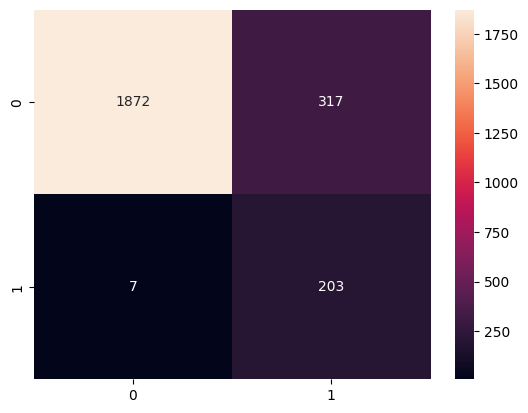

Accuraccy score: 0.8649437265527303

classification report: 
              precision    recall  f1-score   support

           0       1.00      0.86      0.92      2189
           1       0.39      0.97      0.56       210

    accuracy                           0.86      2399
   macro avg       0.69      0.91      0.74      2399
weighted avg       0.94      0.86      0.89      2399

Mean ROC AUC: 0.928


In [25]:
clf_rus = BalancedRandomForestClassifier(n_estimators=10)
clf_rus.fit(X_train,np.ravel(y_train))
y_pred_clf_rus = clf_rus.predict(X_valid)

modelAnalysis(clf_rus, y_pred_clf_rus)

En cambio, este algoritmo fue muy bueno en reducir la cantidad de falsos negativos a la vez que manteniendo la proporción de estimación de los negativos

#### 4) Ensemble

El modelo EasyEnsemble involucra crear muestras balanceadas del dataset de entrenamiento, seleccionando todas las muestras de la clase minoritaria y un subconjuto de la clase mayoritaria. En lugar de usar 'pruned decision trees', 'boosted decision trees' son usados para cada subconjunto, específicamente el algoritmo AdaBoost. Este funciona primero ajustando un árbol de decisión con los datos originales y luego determinando los errores hechos por el modelo, para después dar peso a las muestras en el dataset que provocaron dichos errores, con el propósito de darle más importancia a las muestras mal clasificadas y menos a las que fueron clasificadas correctamente. Un siguiente árbol luego es ajustado en el dataset con peso, buscando corregir los errores. El proceso es repetido para un número dado de árboles de decisión.

El modelo EasyEnsembleClassifier de la librería imbalanced-learn nos provee de una implementación de esta técnica.

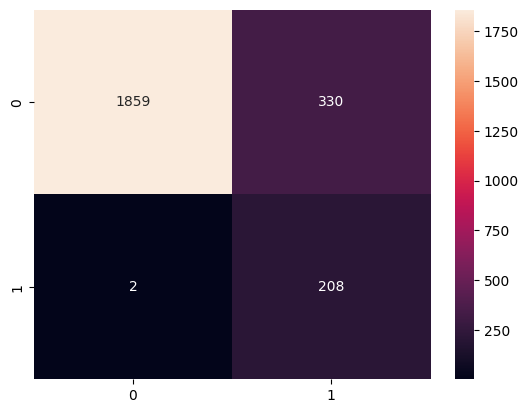

Accuraccy score: 0.8616090037515631

classification report: 
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2189
           1       0.39      0.99      0.56       210

    accuracy                           0.86      2399
   macro avg       0.69      0.92      0.74      2399
weighted avg       0.95      0.86      0.89      2399

Mean ROC AUC: 0.937


In [26]:
clf_ens1= EasyEnsembleClassifier(n_estimators=10)
clf_ens1.fit(X_train,np.ravel(y_train))
y_pred_clf_ens1 = clf_ens1.predict(X_valid)

modelAnalysis(clf_ens1, y_pred_clf_ens1)

Este algoritmo en conjunto con el anterior han sido los mejores relativamente a RandomForest, ya que este también logró reducir significativamente la cantidad de falsos negativos.

Variación del algoritmo anterior (parámetro 'sampling_strategy = 'not minority''):

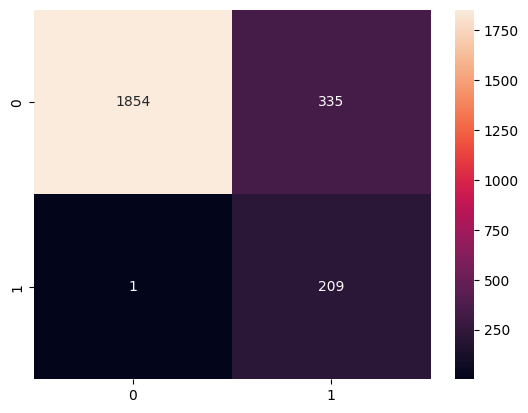

Accuraccy score: 0.8599416423509796

classification report: 
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2189
           1       0.38      1.00      0.55       210

    accuracy                           0.86      2399
   macro avg       0.69      0.92      0.74      2399
weighted avg       0.95      0.86      0.89      2399

Mean ROC AUC: 0.937


In [27]:
clf_ensv= EasyEnsembleClassifier(n_estimators=10, sampling_strategy = 'not minority')
clf_ensv.fit(X_train,np.ravel(y_train))
y_pred_clf_ensv = clf_ensv.predict(X_valid)

modelAnalysis(clf_ensv, y_pred_clf_ensv)

Esta variación se comportó apenas mejor que el anterior

#### Comparacion de modelos

Text(0.5, 1.0, 'Segundo ensemmble')

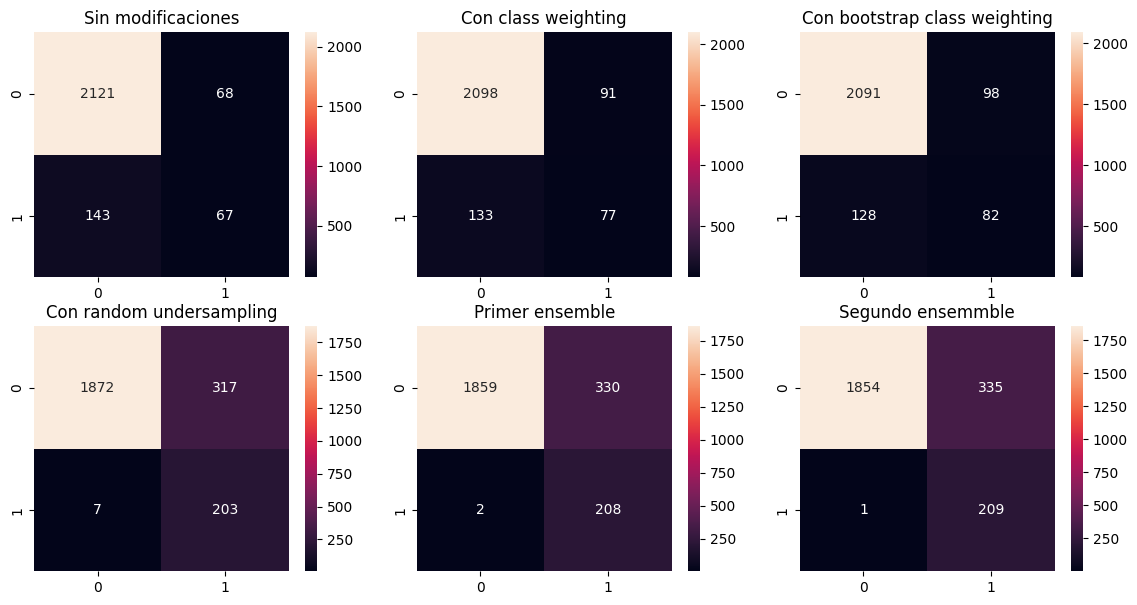

In [28]:
fig, ax = plt.subplots(2,3,figsize=(14,7))

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(y_pred_rf)), annot= True , fmt='d', ax=ax[0][0])
ax[0][0].set_title('Sin modificaciones')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(y_pred_clf_cw)), annot= True , fmt='d', ax=ax[0][1])
ax[0][1].set_title('Con class weighting')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(y_pred_clf_bc)), annot= True , fmt='d', ax=ax[0][2])
ax[0][2].set_title('Con bootstrap class weighting')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(y_pred_clf_rus)), annot= True , fmt='d', ax=ax[1][0])
ax[1][0].set_title('Con random undersampling')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(y_pred_clf_ens1)), annot= True , fmt='d', ax=ax[1][1])
ax[1][1].set_title('Primer ensemble')

sns.heatmap(confusion_matrix(np.ravel(y_valid),np.ravel(y_pred_clf_ensv)), annot= True , fmt='d', ax=ax[1][2])
ax[1][2].set_title('Segundo ensemmble')

Concluimos que el mejor algoritmo en todo sentido de performance ha sido el que utilizamos random undersampling

## OneClassSVM

Este algoritmo se basa en la deteccion de outliers, siendo estos las muestras de clases minoritarias. Se entrena aprendiendo en la clase mayoritaria, los inliers, para asi poder predecir cuando un dato esta fuera de lo commun. En este caso vamos a aplicarlo, entrenando solo con nuestros datos falsos de nuestro target

In [349]:
from sklearn.svm import OneClassSVM
from collections import Counter

df_zeros = df_processed[df_processed['is_potentially_hazardous_asteroid'] == 0].dropna()

X_zeros = df_zeros.drop(columns='is_potentially_hazardous_asteroid')
y_zeros = df_zeros['is_potentially_hazardous_asteroid']


df_ones = df_processed[df_processed['is_potentially_hazardous_asteroid'] == 1].dropna()

X_ones = df_ones.drop(columns='is_potentially_hazardous_asteroid')
y_ones = df_ones['is_potentially_hazardous_asteroid']

X_train_zeros, X_rem_zeros, y_train_zeros, y_rem_zeros = train_test_split(X_zeros,y_zeros, train_size=0.8,stratify=y_zeros, random_state=42)
X_valid_zeros, X_test_zeros, y_valid_zeros, y_test_zeros = train_test_split(X_rem_zeros,y_rem_zeros, test_size=0.5,stratify=y_rem_zeros, random_state=42)

### Primer prueba

In [365]:
one_class_svm = OneClassSVM(nu=0.1,gamma='auto',kernel='rbf',degree=6).fit(X_train[ y_train['is_potentially_hazardous_asteroid']== 0])

prediction = one_class_svm.predict(X_valid)
prediction = [1 if i==-1 else 0 for i in prediction]

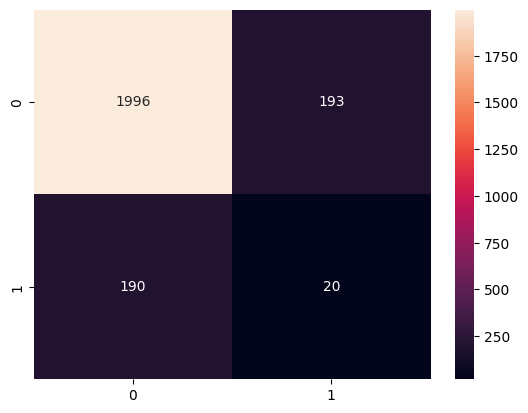

Accuraccy score: 0.8403501458941226

classification report: 
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2189
           1       0.09      0.10      0.09       210

    accuracy                           0.84      2399
   macro avg       0.50      0.50      0.50      2399
weighted avg       0.84      0.84      0.84      2399



In [367]:
sns.heatmap(confusion_matrix(y_valid,prediction), annot= True , fmt='d')
plt.show()
print(f'Accuraccy score: {accuracy_score(y_valid,prediction)}\n')
print(f'classification report: \n{classification_report(y_valid,prediction)}')

Podemos apreciar que esta primer prueba no ha sido satisfactoria respecto a reducir los falsos negativos

#### Hypertuneando los parametros de SVM con Grid Search

In [108]:
oc_svm = OneClassSVM()
hyp_svm = GridSearchCV(estimator= oc_svm,param_grid = parameters,scoring='f1_micro',verbose=2)
hyp_svm.fit(X_train[ y_train['is_potentially_hazardous_asteroid']== False], y_train[y_train['is_potentially_hazardous_asteroid']== False])

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
[CV] END .....degree=1, gamma=0.001, kernel=linear, nu=0.001; total time=   0.0s
[CV] END .....degree=1, gamma=0.001, kernel=linear, nu=0.001; total time=   0.0s
[CV] END .....degree=1, gamma=0.001, kernel=linear, nu=0.001; total time=   0.0s
[CV] END .....degree=1, gamma=0.001, kernel=linear, nu=0.001; total time=   0.0s
[CV] END .....degree=1, gamma=0.001, kernel=linear, nu=0.001; total time=   0.0s
[CV] END ......degree=1, gamma=0.001, kernel=linear, nu=0.01; total time=   0.1s
[CV] END ......degree=1, gamma=0.001, kernel=linear, nu=0.01; total time=   0.1s
[CV] END ......degree=1, gamma=0.001, kernel=linear, nu=0.01; total time=   0.1s
[CV] END ......degree=1, gamma=0.001, kernel=linear, nu=0.01; total time=   0.1s
[CV] END ......degree=1, gamma=0.001, kernel=linear, nu=0.01; total time=   0.1s
[CV] END .......degree=1, gamma=0.001, kernel=linear, nu=0.1; total time=   0.9s
[CV] END .......degree=1, gamma=0.001, kernel

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
480 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 1666, in fit
    super().fit(X, np.ones(_num_samples(X)), sample_weight=sample_weight)
  File "/workspace/.pyenv_mirror/user/current/lib/python3.8/site-pac

GridSearchCV(estimator=OneClassSVM(),
             param_grid={'degree': [1, 2, 3, 4],
                         'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'nu': [0.001, 0.01, 0.1, 1]},
             scoring='f1_micro', verbose=2)

In [115]:
# Guardado del modelo

pickle.dump(hyp_svm.best_estimator_, open("finalized_model.sav", 'wb'))

In [368]:
prediction2 = hyp_svm.best_estimator_.predict(X_valid)
prediction2 = [1 if i==-1 else 0 for i in pred]

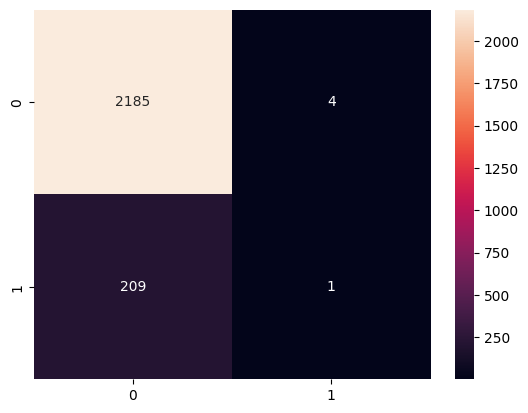

Accuraccy score: 0.9112130054189246

classification report: 
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2189
           1       0.20      0.00      0.01       210

    accuracy                           0.91      2399
   macro avg       0.56      0.50      0.48      2399
weighted avg       0.85      0.91      0.87      2399



In [370]:
sns.heatmap(confusion_matrix(y_valid,prediction2), annot= True , fmt='d')
plt.show()
print(f'Accuraccy score: {accuracy_score(y_valid,prediction2)}\n')
print(f'classification report: \n{classification_report(y_valid,prediction2)}')

Consideramos que nos falta estudio respecto al algoritmo y como aplicarlo correctamente, ya que luego del hypertune los resultados siguen sin ser satisfactorios

# Mejores modelos

### Tuneando los hiperparametros de los mejores modelos

In [420]:
# Se eliminan entradas nan de X_test

y_test = y_test[np.logical_not(X_test.isna().any(axis=1))]
X_test = X_test[np.logical_not(X_test.isna().any(axis=1))]

#### para RandomForest, tomamos como mejor modelo al de Random Undersampling

In [405]:
parameters= {"criterion":["gini","entropy"],'max_depth':[50,100,175],'min_samples_leaf':[1,5,8],'max_features':['sqrt', 'log2']}

clf_h = GridSearchCV(estimator= clf_rus,param_grid = parameters,scoring='recall',verbose=3)
clf_h.fit(X_valid,np.ravel(y_valid))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1;, score=0.905 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1;, score=0.976 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1;, score=0.929 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1;, score=0.929 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=1;, score=0.929 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5;, score=0.976 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5;, score=0.976 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_leaf=5;, score=0.976 total time=   0.0s
[CV 4/5] END criterion=gin

GridSearchCV(estimator=BalancedRandomForestClassifier(n_estimators=10),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [50, 100, 175],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 8]},
             scoring='recall', verbose=3)

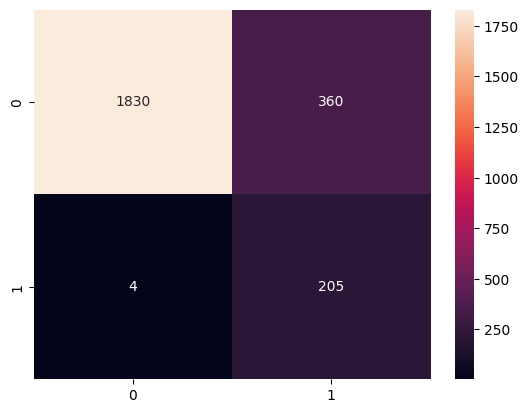

Accuraccy score: 0.8482701125468946

classification report: 
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      2190
           1       0.36      0.98      0.53       209

    accuracy                           0.85      2399
   macro avg       0.68      0.91      0.72      2399
weighted avg       0.94      0.85      0.88      2399

Mean ROC AUC: 0.934


In [419]:
y_pred_best_rf = clf_h.best_estimator_.predict(X_test)

sns.heatmap(confusion_matrix(np.ravel(y_test),np.ravel(y_pred_best_rf)), annot= True , fmt='d')
plt.show()
print(f'Accuraccy score: {accuracy_score(np.ravel(y_test),np.ravel(y_pred_best_rf))}\n')
print(f'classification report: \n{classification_report(np.ravel(y_test),np.ravel(y_pred_best_rf))}')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf_h.best_estimator_, X_united, np.ravel(y_united), scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Logramos conseguir mejorar más aun este algoritmo comparando con el resultado sin hypertuning

#### para LogisticRegression, tomamos como mejor modelo el de Penalizacion

In [423]:
parameters= {"penalty":["l1","l2","elasticnet"],'C':[0.01,0.1,1],'solver':["newton-cg", "lbfgs", "liblinear"]}

clf_h_lr = GridSearchCV(estimator= lr_pen,param_grid = parameters,scoring='recall',verbose=3)
clf_h_lr.fit(X_valid,np.ravel(y_valid))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.929 total time=   0.0s
[CV 2/5] END C=0.01, penalty=l1, solver=libli

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
75 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packa

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=1,
                                          solver='newton-cg'),
             param_grid={'C': [0.01, 0.1, 1],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='recall', verbose=3)

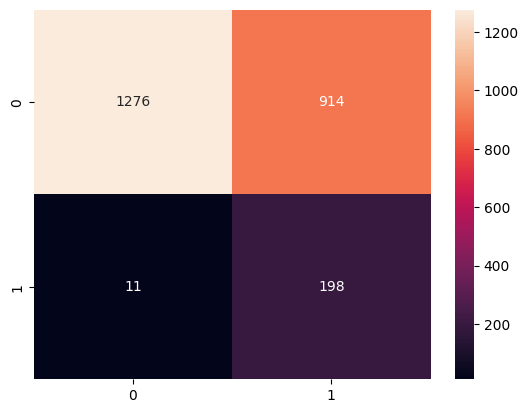

Accuraccy score: 0.614422676115048

classification report: 
              precision    recall  f1-score   support

           0       0.99      0.58      0.73      2190
           1       0.18      0.95      0.30       209

    accuracy                           0.61      2399
   macro avg       0.58      0.77      0.52      2399
weighted avg       0.92      0.61      0.70      2399

Mean ROC AUC: 0.891


In [424]:
y_pred_best_lr = clf_h_lr.best_estimator_.predict(X_test)

sns.heatmap(confusion_matrix(np.ravel(y_test),np.ravel(y_pred_best_lr)), annot= True , fmt='d')
plt.show()
print(f'Accuraccy score: {accuracy_score(np.ravel(y_test),np.ravel(y_pred_best_lr))}\n')
print(f'classification report: \n{classification_report(np.ravel(y_test),np.ravel(y_pred_best_lr))}')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf_h_lr.best_estimator_, X_united, np.ravel(y_united), scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Para este también se logró una mejora respecto al que usamos anteriormente sin hypertuning

## Conclusiones

Luego de probar con las técnicas de balanceo mencionadas, llegamos a la conclusión que la técnica que mejor facilita al modelo a
     predecir con un recall bajo para los is_potentially_hazardous_asteroid == True es la penalización resecto a Logistic Regression con un recall de 0.95, y Random Undersampling con un recall de 0.98, lo cual es muy importante para nosotros ya que queremos que los falsos negativos sean los menores posibles dado que una prediccion erronea de ese tipo tendria resultados catastroficos en la practica.

## Como expandiriamos el proyecto

Este proyecto ha sido apuntado como trabajo de investigación. Continuaremos formalizando esto para poder
      plantear una investigación más profunda y poder llegar a conclusiones más fuertes que abarquen más que solo este dataset putual.
      Para esto aplicariamos una variedas más extensiva de modelos y técnicas, y como obejtivo final
      compartir los resultados de nuestra investigación como aporte al conocimiento colectivo en este campo.

### Bibliografía


Clasificación de órbita:
- https://www.comet-toolbox.com/neos.html  


VIF:
- https://www.statology.org/how-to-calculate-vif-in-python/ 
- https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/


BoxCox: 
- https://statologos.com/caja-cox-transformacion-python/
- https://www.geeksforgeeks.org/box-cox-transformation-using-python/


LogisticRegression:  
- https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/


RandomForest:
- https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/
- https://programmerclick.com/article/59911454282/

